<a href="https://colab.research.google.com/github/belanatal/PosPUCRio/blob/main/MVP-SprintIIa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PUC Rio: Pós Graduação em Ciência de Dados e Analytics**

**MVP Sprint I: Análise de Dados e Boas Práticas (40530010055_20230_01)**

Aluna: Isabela Fernanda Natal Batista Abreu Gomes

Maio/2023

# **Introdução**

## Programa para obtenção, tratamento e análise do histórico de Energia Natural Afluente (ENA), da Energia Armazenada (EArm), da Demanda/Carga e do Custo Marginal da Operação (CMO) por subsistema, a partir da área de Dados Abertos do Operador Nacional do Sistema Elétrico (ONS): [Arquitetura Aberta](https://dados.ons.org.br/)

> Bloco com recuo




> No Brasil, a projeção de preços da energia elétrica baseia-se na previsão, centralizada, de despacho das usinas pelo Operador Nacional do Sistema Elétrico (ONS).

> Em linhas gerais, o preço da energia, também chamado de Preço de Liquidação das Diferenças (PLD) tem como base o Custo Marginal da Operação (CMO), dado pelo planejamento da operação hidrotérmica do Sistema Interligado Nacional. Os modelos utilizados para projeção oficial do despacho das usinas pelo ONS (Operador Nacional do Sistema) denominam-se NEWAVE, DECOMP e DESSEM, todos desenvolvidos e fornecidos pelo Centro de Pesquisas da Eletrobras (CEPEL), conforme ilustrado na Figura 1.

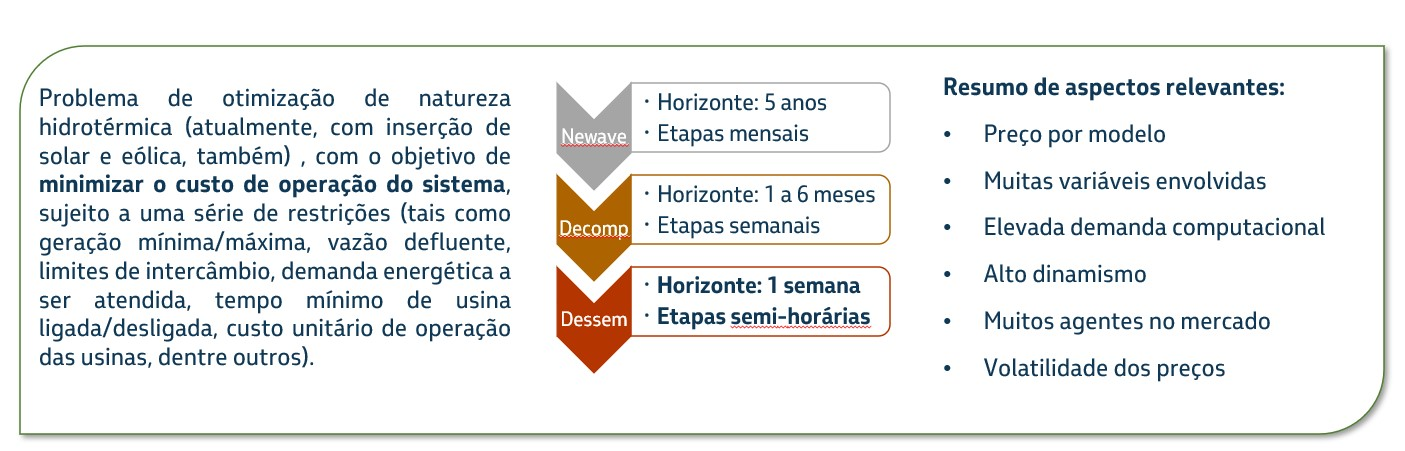

Figura 1 - Resumo do problema de planejamento eletroenergético brasileiro.

> Para a projeção do preço da energia elétrica, uma série de grandezas são utilizadas como entrada. Uma vez que a matriz eletroenergética brasileira é predominantemente hidráulica (e os modelos consideram este aspecto no equacionamento do problema de otimização), a diferença entre as vazões previstas e verificadas dos postos associados às usinas hidroelétricas responde por cerca de 50% das variações no PLD/CMO, conforme ilustrado na Figura 2, disponibilizada pela Câmara de Comercialização de Energia (CCEE). A Energia Armazenada e a Carga também desempenham papel relevante na influência do PLD/CMO. Juntas, as três grandezas respondem por mais de 70% das variações no custo marginal da operação sendo, portanto, as variáveis de interesse na primeira abordagem deste MVP.

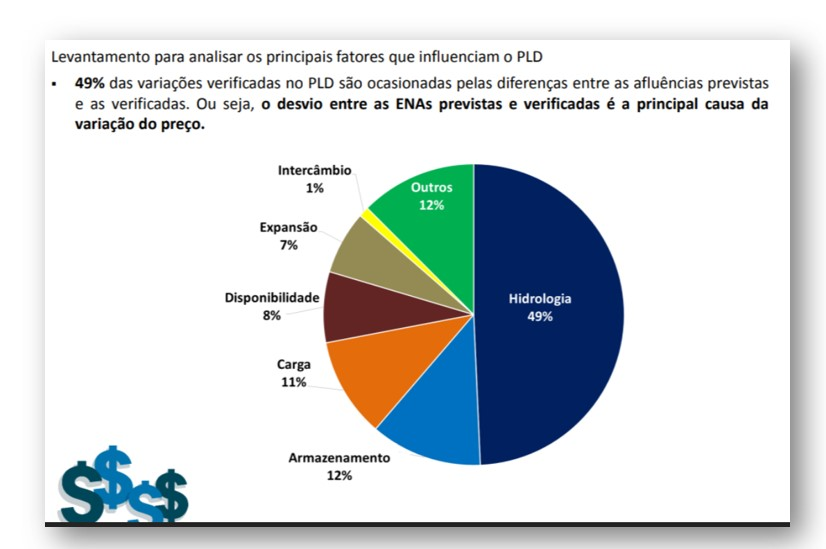

Figura 2 - Variação do PLD/CMO por variável de entrada nos modelos de planejamento eletroenergético do SIN. Fonte: CCEE


> Neste contexto, considerando a atuação na área de Inteligência de Mercado de Gás e Energia em um dos principais agentes geradores do Brasil, faz sentido estruturarmos a coleta e tratamento dos dados referentes às grandezas mencionadas, visando à melhor tomada de decisão sob a ótica da operação do parque e da comercialização e logística do gás e da energia elétrica.





# **Seção I: Obtenção e Tratamento Inicial dos Dados**


1.   [Energia Natural Afluente (ENA) por Subsistema](https://dados.ons.org.br/dataset/ena-diario-por-subsistema)
2.   [Energia Armazenada (EArm) por Subsistema](https://dados.ons.org.br/dataset/ear-diario-por-subsistema)
3.   [Demanda por Subsistema](https://dados.ons.org.br/dataset/carga-energia)
4.   [Custo Marginal da Operação (CMO) Semanal por Subsistema](https://dados.ons.org.br/dataset/cmo-semanal)





> Diariamente, o Operador Nacional do Sistema Elétrico disponibiliza os dados verificados das grandezas supracitadas, para cada um dos 4 subsistemas (Sudeste, Sul, Nordeste e Norte) que compõem eletroenergeticamente o Sistema Interligado Nacional. Para atender ao presente trabalho, estes dados serão tratados, manipulados, pré-processados e avaliados de modo que, em etapas futuras, seja possível aplicar técnicas e algoritmos de Machine Learning a eles, com o objetivo de tentar realizar predições e análises de sensibilidade de Custos Marginais da Operação futuros, por fora dos modelos oficiais.

> Trata-se, portanto, de um problema de Aprendizado Supervisionado, considerando as principais grandezas envolvidas no cálculo do CMO, segundo a Câmara de Comercialização de Energia.



Inicialmente, iremos importar e avaliar (utilizando a biblioteca Pandas, para fazer uma rápida análise exploratória) os dataset de "entrada", variáveis explicativas para a obtenção do CMO: ENA, EArm e Demanda, nesta ordem.

In [1]:
# Primeiro bloco: Importação das bibliotecas e módulos
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")
#
# Importando as bibliotecas pandas, matplotlib (pyplot), seaborn e datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
#
## Transformações Numéricas e ML
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.preprocessing import StandardScaler # para padronização
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import mean_squared_error # métrica de avaliação MSE
from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.neighbors import KNeighborsRegressor # algoritmo KNN
from sklearn.tree import DecisionTreeRegressor # algoritmo Árvore de Regressão
from sklearn.svm import SVR # algoritmo SVM
#
## Transformações Categóricas
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

## Energia Natural Afluente: ENA

***ENA DIÁRIO POR SUBSISTEMA*** (Segundo o ONS)

Dados das grandezas de energia natural afluente (ENA) dos reservatórios com periodicidade diária por Subsistemas.

A Energia Natural Afluente (ENA) Bruta representa a energia produzível pela usina e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios.

Como esses dados podem ser utilizados: os dados podem servir de insumo para estudos energéticos e projeção do custo marginal de operação. Contudo, saiba que os dados disponibilizados fazem parte de um processo de consistência recorrente e, portanto, podem ser atualizados após a sua publicação.

In [2]:
# Seção I.1: Programa para obtenção das Energias Naturais Afluentes - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.
# ENA - Arquivos com os dados anuais, com histórico desde 2001
ano_zero=2001
ano_inicio=ano_zero+1
data_fim=datetime.datetime.now() - datetime.timedelta(days=5) #ano vigente, considerando um possível atraso de até 5 dias na publicação, o que é comum na virada de ano
ano_fim=data_fim.strftime("%Y")
ano_fim=int(ano_fim)
print(data_fim)
print(ano_fim)

2023-06-29 20:31:19.044302
2023


In [3]:
#Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
#Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
ena=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
ena=pd.DataFrame(ena)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)
    ena_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    ena_ano=pd.DataFrame(ena_ano)
    ena=pd.concat([ena,ena_ano])
print(ena)

    id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
0               N          NORTE  2001-01-01            10154.000000   
1              NE       NORDESTE  2001-01-01            13472.000000   
2               S            SUL  2001-01-01             7703.000000   
3              SE        SUDESTE  2001-01-01            39186.000000   
4               N          NORTE  2001-01-02             9590.000000   
..            ...            ...         ...                     ...   
731            SE        SUDESTE  2023-07-02            24593.136719   
732             N          NORTE  2023-07-03             5405.924805   
733            NE       NORDESTE  2023-07-03             2040.828979   
734             S            SUL  2023-07-03             5856.232910   
735            SE        SUDESTE  2023-07-03            24089.433594   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                        122.339996                   9033.000000 

In [4]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
ena.head(10)

id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
0             N          NORTE  2001-01-01                 10154.0   
1            NE       NORDESTE  2001-01-01                 13472.0   
2             S            SUL  2001-01-01                  7703.0   
3            SE        SUDESTE  2001-01-01                 39186.0   
4             N          NORTE  2001-01-02                  9590.0   
5            NE       NORDESTE  2001-01-02                 13551.0   
6             S            SUL  2001-01-02                  6730.0   
7            SE        SUDESTE  2001-01-02                 41230.0   
8             N          NORTE  2001-01-03                  9066.0   
9            NE       NORDESTE  2001-01-03                 13551.0   

   ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                      122.339996                        9033.0   
1                      101.480003                       13385.0   
2                      160.910004                        7703.0   
3                       86.980003                       37611.0   
4                      115.550003                        8091.0   
5                      102.080002                       13465.0   
6                      140.580002                        6730.0   
7                       91.519997                       40063.0   
8                      109.239998                        7213.0   
9                      102.080002                       13461.0   

   ena_armazenavel_regiao_percentualmlt  
0                            108.839996  
1                            100.830002  
2                            160.910004  
3                             83.489998  
4                             97.489998  
5                            101.430000  
6                            140.580002  
7                             88.930000  
8                             86.910004  
9                            101.400002

In [5]:
# Conferindo as últimas 10 linhas
ena.tail(10)

id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
726             S            SUL  2023-07-01             6754.268066   
727            SE        SUDESTE  2023-07-01            25148.783203   
728             N          NORTE  2023-07-02             5395.450195   
729            NE       NORDESTE  2023-07-02             2062.243896   
730             S            SUL  2023-07-02             6170.861816   
731            SE        SUDESTE  2023-07-02            24593.136719   
732             N          NORTE  2023-07-03             5405.924805   
733            NE       NORDESTE  2023-07-03             2040.828979   
734             S            SUL  2023-07-03             5856.232910   
735            SE        SUDESTE  2023-07-03            24089.433594   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
726                       61.773899                   6690.645020   
727                       98.066002                  24677.220703   
728                      102.559700                   5140.021973   
729                       54.628601                   2036.504028   
730                       56.438099                   5997.033203   
731                       95.899300                  23651.871094   
732                      102.758797                   5180.569824   
733                       54.786499                   2017.948975   
734                       53.560600                   5796.856934   
735                       93.935204                  23822.246094   

     ena_armazenavel_regiao_percentualmlt  
726                             61.192001  
727                             96.227203  
728                             97.704399  
729                             53.946701  
730                             54.848301  
731                             92.228897  
732                             98.475197  
733                             54.172199  
734                             53.017502  
735                             92.893303

In [6]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(ena)/4

8219.0

In [7]:
# Verificando os tipos de coluna do dataframe ena
ena.dtypes

id_subsistema                            object
nom_subsistema                           object
ena_data                                 object
ena_bruta_regiao_mwmed                  float64
ena_bruta_regiao_percentualmlt          float64
ena_armazenavel_regiao_mwmed            float64
ena_armazenavel_regiao_percentualmlt    float64
dtype: object

In [8]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
ena['nom_subsistema']=ena['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [9]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
ena=ena.rename(columns = {'ena_data':'Data'})
print(ena)

    id_subsistema nom_subsistema        Data  ena_bruta_regiao_mwmed  \
0               N          Norte  2001-01-01            10154.000000   
1              NE       Nordeste  2001-01-01            13472.000000   
2               S            Sul  2001-01-01             7703.000000   
3              SE        Sudeste  2001-01-01            39186.000000   
4               N          Norte  2001-01-02             9590.000000   
..            ...            ...         ...                     ...   
731            SE        Sudeste  2023-07-02            24593.136719   
732             N          Norte  2023-07-03             5405.924805   
733            NE       Nordeste  2023-07-03             2040.828979   
734             S            Sul  2023-07-03             5856.232910   
735            SE        Sudeste  2023-07-03            24089.433594   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                        122.339996                   9033.000000 

In [10]:
# Alterando o tipo da coluna "Data"
ena['Data'] = pd.to_datetime(ena['Data'])

In [11]:
# Verificando os tipos de coluna do dataframe ena
ena.dtypes

id_subsistema                                   object
nom_subsistema                                  object
Data                                    datetime64[ns]
ena_bruta_regiao_mwmed                         float64
ena_bruta_regiao_percentualmlt                 float64
ena_armazenavel_regiao_mwmed                   float64
ena_armazenavel_regiao_percentualmlt           float64
dtype: object

In [12]:
# Reordenando o dataframe ena, pela coluna Data (em ordem decrescente)
ena=ena.sort_values(by='Data', ascending=False)
ena.head(20)

id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
735            SE        Sudeste 2023-07-03            24089.433594   
734             S            Sul 2023-07-03             5856.232910   
733            NE       Nordeste 2023-07-03             2040.828979   
732             N          Norte 2023-07-03             5405.924805   
731            SE        Sudeste 2023-07-02            24593.136719   
730             S            Sul 2023-07-02             6170.861816   
729            NE       Nordeste 2023-07-02             2062.243896   
728             N          Norte 2023-07-02             5395.450195   
725            NE       Nordeste 2023-07-01             2057.245117   
724             N          Norte 2023-07-01             5554.017090   
727            SE        Sudeste 2023-07-01            25148.783203   
726             S            Sul 2023-07-01             6754.268066   
723            SE        Sudeste 2023-06-30            24982.824219   
722             S            Sul 2023-06-30             7630.007812   
721            NE       Nordeste 2023-06-30             2057.535889   
720             N          Norte 2023-06-30             5631.702148   
717            NE       Nordeste 2023-06-29             2064.305908   
716             N          Norte 2023-06-29             5734.956055   
719            SE        Sudeste 2023-06-29            26751.724609   
718             S            Sul 2023-06-29             8912.409180   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
735                       93.935204                  23822.246094   
734                       53.560600                   5796.856934   
733                       54.786499                   2017.948975   
732                      102.758797                   5180.569824   
731                       95.899300                  23651.871094   
730                       56.438099                   5997.033203   
729                       54.628601                   2036.504028   
728                      102.559700                   5140.021973   
725                       54.496201                   2047.949951   
724                      105.573898                   5339.458984   
727                       98.066002                  24677.220703   
726                       61.773899                   6690.645020   
723                       76.703903                  24701.189453   
722                       73.045700                   7528.499023   
721                       44.946701                   2057.535889   
720                       52.558601                   5454.877930   
717                       45.094601                   2064.305908   
716                       53.522202                   5533.232910   
719                       82.134903                  26327.130859   
718                       85.322800                   8117.231934   

     ena_armazenavel_regiao_percentualmlt  
735                             92.893303  
734                             53.017502  
733                             54.172199  
732                             98.475197  
731                             92.228897  
730                             54.848301  
729                             53.946701  
728                             97.704399  
725                             54.249901  
724                            101.495399  
727                             96.227203  
726                             61.192001  
723                             75.839203  
722                             72.073998  
721                             44.946701  
720                             50.908401  
717                             45.094601  
716                             51.639599  
719                             80.831200  
718                             77.710197

## Energia Armazenada: EArm

***EAR DIÁRIO POR SUBSISTEMA*** (Segundo o ONS)

Dados das grandezas de energia armazenada (EAR) em periodicidade diária por Subsistemas.

A Energia Armazenada (EAR) representa a energia associada ao volume de água disponível nos reservatórios que pode ser convertido em geração na própria usina e em todas as usinas à jusante na cascata. A grandeza de EAR leva em conta nível verificado nos reservatórios na data de referência. A grandeza de EAR máxima representa a capacidade de armazenamento caso todos os reservatórios do sistema estivessem cheios. A grandeza de EAR para o subsistema à jusante considera a utilização da água do reservatório para produzir energia em uma usina à jusante que está em um subsistema diferente.

Como esses dados podem ser utilizados: os dados podem servir de insumo para estudos energéticos e projeção do custo marginal de operação. Contudo, saiba que os dados disponibilizados fazem parte de um processo de consistência recorrente e, portanto, podem ser atualizados após a sua publicação.

In [13]:
# Seção I.2: Programa para obtenção das Energias Armazenadas - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# EArm - Arquivos com os dados anuais, com histórico desde 2001.
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas)
# Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
earm=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
earm=pd.DataFrame(earm)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)
    earm_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    earm_ano=pd.DataFrame(earm_ano)
    earm=pd.concat([earm,earm_ano])
print (earm)

    id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
0              NE       NORDESTE  2001-01-01        49967.000000   
1               N          NORTE  2001-01-01        12311.000000   
2              SE        SUDESTE  2001-01-01       159081.000000   
3               S            SUL  2001-01-01        14176.000000   
4              NE       NORDESTE  2001-01-02        49967.000000   
..            ...            ...         ...                 ...   
731             S            SUL  2023-07-02        20459.242188   
732            NE       NORDESTE  2023-07-03        51691.226562   
733             N          NORTE  2023-07-03        15302.396484   
734            SE        SUDESTE  2023-07-03       204615.328125   
735             S            SUL  2023-07-03        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                  18699.000000                        37.419998  
1                   9137.000000                  

In [14]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
earm.head(10)

id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
0            NE       NORDESTE  2001-01-01             49967.0   
1             N          NORTE  2001-01-01             12311.0   
2            SE        SUDESTE  2001-01-01            159081.0   
3             S            SUL  2001-01-01             14176.0   
4            NE       NORDESTE  2001-01-02             49967.0   
5             N          NORTE  2001-01-02             12311.0   
6            SE        SUDESTE  2001-01-02            159081.0   
7             S            SUL  2001-01-02             14176.0   
8            NE       NORDESTE  2001-01-03             49967.0   
9             N          NORTE  2001-01-03             12311.0   

   ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                     18699.0                        37.419998  
1                      9137.0                        74.220001  
2                     46315.0                        29.110001  
3                     12857.0                        90.690002  
4                     18851.0                        37.730000  
5                      9327.0                        75.760002  
6                     46850.0                        29.450001  
7                     12920.0                        91.139999  
8                     19047.0                        38.119999  
9                      9453.0                        76.779999

In [15]:
# Conferindo as últimas 10 linhas
earm.tail(10)

id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
726            SE        SUDESTE  2023-07-01       204615.328125   
727             S            SUL  2023-07-01        20459.242188   
728            NE       NORDESTE  2023-07-02        51691.226562   
729             N          NORTE  2023-07-02        15302.396484   
730            SE        SUDESTE  2023-07-02       204615.328125   
731             S            SUL  2023-07-02        20459.242188   
732            NE       NORDESTE  2023-07-03        51691.226562   
733             N          NORTE  2023-07-03        15302.396484   
734            SE        SUDESTE  2023-07-03       204615.328125   
735             S            SUL  2023-07-03        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
726               176624.718750                        86.320396  
727                18089.039062                        88.415001  
728                43736.382812                        84.610802  
729                14917.125977                        97.482300  
730               176560.187500                        86.288803  
731                18077.750000                        88.359802  
732                43491.070312                        84.136299  
733                14880.362305                        97.241997  
734               176452.671875                        86.236298  
735                17987.460938                        87.918503

In [16]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(earm)/4

8219.0

In [17]:
# Verificando os tipos de coluna do dataframe earm
earm.dtypes

id_subsistema                       object
nom_subsistema                      object
ear_data                            object
ear_max_subsistema                 float64
ear_verif_subsistema_mwmes         float64
ear_verif_subsistema_percentual    float64
dtype: object

In [18]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
earm['nom_subsistema']=earm['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [19]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
earm=earm.rename(columns = {'ear_data':'Data'})
print(earm)

    id_subsistema nom_subsistema        Data  ear_max_subsistema  \
0              NE       Nordeste  2001-01-01        49967.000000   
1               N          Norte  2001-01-01        12311.000000   
2              SE        Sudeste  2001-01-01       159081.000000   
3               S            Sul  2001-01-01        14176.000000   
4              NE       Nordeste  2001-01-02        49967.000000   
..            ...            ...         ...                 ...   
731             S            Sul  2023-07-02        20459.242188   
732            NE       Nordeste  2023-07-03        51691.226562   
733             N          Norte  2023-07-03        15302.396484   
734            SE        Sudeste  2023-07-03       204615.328125   
735             S            Sul  2023-07-03        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                  18699.000000                        37.419998  
1                   9137.000000                  

In [20]:
# Alterando o tipo da coluna "Data"
earm['Data'] = pd.to_datetime(earm['Data'])

In [21]:
# Verificando novamente os tipos de coluna do dataframe earm
earm.dtypes

id_subsistema                              object
nom_subsistema                             object
Data                               datetime64[ns]
ear_max_subsistema                        float64
ear_verif_subsistema_mwmes                float64
ear_verif_subsistema_percentual           float64
dtype: object

In [22]:
# Reordenando o dataframe earm, pela coluna Data (em ordem decrescente)
earm=earm.sort_values(by='Data', ascending=False)
earm.head(20)

id_subsistema nom_subsistema       Data  ear_max_subsistema  \
735             S            Sul 2023-07-03        20459.242188   
734            SE        Sudeste 2023-07-03       204615.328125   
733             N          Norte 2023-07-03        15302.396484   
732            NE       Nordeste 2023-07-03        51691.226562   
731             S            Sul 2023-07-02        20459.242188   
730            SE        Sudeste 2023-07-02       204615.328125   
729             N          Norte 2023-07-02        15302.396484   
728            NE       Nordeste 2023-07-02        51691.226562   
725             N          Norte 2023-07-01        15302.396484   
724            NE       Nordeste 2023-07-01        51691.226562   
727             S            Sul 2023-07-01        20459.242188   
726            SE        Sudeste 2023-07-01       204615.328125   
723             S            Sul 2023-06-30        20459.242188   
722            SE        Sudeste 2023-06-30       204615.328125   
721             N          Norte 2023-06-30        15302.396484   
720            NE       Nordeste 2023-06-30        51691.226562   
717             N          Norte 2023-06-29        15302.396484   
716            NE       Nordeste 2023-06-29        51691.226562   
719             S            Sul 2023-06-29        20459.242188   
718            SE        Sudeste 2023-06-29       204615.328125   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
735                17987.460938                        87.918503  
734               176452.671875                        86.236298  
733                14880.362305                        97.241997  
732                43491.070312                        84.136299  
731                18077.750000                        88.359802  
730               176560.187500                        86.288803  
729                14917.125977                        97.482300  
728                43736.382812                        84.610802  
725                14962.750000                        97.780403  
724                43790.351562                        84.715202  
727                18089.039062                        88.415001  
726               176624.718750                        86.320396  
723                18067.609375                        88.310303  
722               176715.421875                        86.364700  
721                15006.278320                        98.064903  
720                43838.164062                        84.807701  
717                15039.379883                        98.281197  
716                43887.312500                        84.902802  
719                18146.056641                        88.693703  
718               176790.359375                        86.401299

## Carga (Demanda) Eletroenergética

***CARGA DE ENERGIA DIÁRIA*** (Segundo o ONS)

Dados de carga por subsistema em base diária, medida em MWmed.

Até fevereiro/2021, os dados representam a carga atendida por usinas despachadas e/ou programadas pelo ONS, com base em dados recebidos pelo Sistema de Supervisão e Controle do ONS. Entre março/2021 e abril/23, os dados representam a carga atendida por usinas despachadas e/ou programadas pelo ONS, com base em dados recebidos pelo Sistema de Supervisão e Controle do ONS, mais a previsão de geração de usinas não despachadas pelo ONS. A partir de 29/04/2023, além dos dados anteriormente considerados, passou a ser incorporado o valor estimado da micro e minigeração distribuída (MMGD), com base em dados meteorológicos previstos.

In [23]:
# Seção I.3: Programa para obtenção da Carga Elétrica - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# Carga - Arquivos com os dados anuais, com histórico desde 2001.
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas)
# Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
carga=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
carga=pd.DataFrame(carga)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)
    carga_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    carga_ano=pd.DataFrame(carga_ano)
    carga=pd.concat([carga,carga_ano])
print(carga)

    id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
0               N                 Norte   2001-01-01            2376.731250
1              NE              Nordeste   2001-01-01            5035.816667
2               S                   Sul   2001-01-01            4925.373750
3              SE  Sudeste/Centro-Oeste   2001-01-01           19729.233333
4               N                 Norte   2001-01-02            2537.383333
..            ...                   ...          ...                    ...
731            SE  Sudeste/Centro-Oeste   2023-07-02           33093.944333
732             N                 Norte   2023-07-03                    NaN
733            NE              Nordeste   2023-07-03                    NaN
734             S                   Sul   2023-07-03                    NaN
735            SE  Sudeste/Centro-Oeste   2023-07-03                    NaN

[32877 rows x 4 columns]


In [24]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
carga.head(10)

id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
0             N                 Norte   2001-01-01            2376.731250
1            NE              Nordeste   2001-01-01            5035.816667
2             S                   Sul   2001-01-01            4925.373750
3            SE  Sudeste/Centro-Oeste   2001-01-01           19729.233333
4             N                 Norte   2001-01-02            2537.383333
5            NE              Nordeste   2001-01-02            5946.387500
6             S                   Sul   2001-01-02            6779.687500
7            SE  Sudeste/Centro-Oeste   2001-01-02           24596.195417
8             N                 Norte   2001-01-03            2540.345833
9            NE              Nordeste   2001-01-03            6188.104167

In [25]:
# Conferindo as últimas 10 linhas
carga.tail(10)

id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
726             S                   Sul   2023-07-01           10884.159708
727            SE  Sudeste/Centro-Oeste   2023-07-01           36323.087000
728             N                 Norte   2023-07-02            6734.179167
729            NE              Nordeste   2023-07-02           10533.034625
730             S                   Sul   2023-07-02            9695.055292
731            SE  Sudeste/Centro-Oeste   2023-07-02           33093.944333
732             N                 Norte   2023-07-03                    NaN
733            NE              Nordeste   2023-07-03                    NaN
734             S                   Sul   2023-07-03                    NaN
735            SE  Sudeste/Centro-Oeste   2023-07-03                    NaN

In [26]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(carga)/4

8219.25

In [27]:
carga_null=(carga['val_cargaenergiamwmed'].isnull() == True)
carganull=carga.loc[carga_null]
print(carganull)

     id_subsistema        nom_subsistema         din_instante  \
132              S                   Sul  2013-02-02 00:00:01   
1337             N                 Norte  2013-12-01 00:00:00   
1338            NE              Nordeste  2013-12-01 00:00:00   
1339             S                   Sul  2013-12-01 00:00:00   
1340            SE  Sudeste/Centro-Oeste  2013-12-01 00:00:00   
124              N                 Norte           2014-02-01   
125             NE              Nordeste           2014-02-01   
126              S                   Sul           2014-02-01   
127             SE  Sudeste/Centro-Oeste           2014-02-01   
392              N                 Norte           2015-04-09   
393             NE              Nordeste           2015-04-09   
394              S                   Sul           2015-04-09   
395             SE  Sudeste/Centro-Oeste           2015-04-09   
380              N                 Norte           2016-04-05   
381             NE       

Constata-se, pela quantidade de dias, que o dataframe "carga" tem uma linha a mais que os dataframes "ena" e "earm". Ao mesclarmos as consultas, desejaremos excluir essa linha a mais.

In [28]:
# Verificando os tipos de coluna do dataframe carga
carga.dtypes

id_subsistema             object
nom_subsistema            object
din_instante              object
val_cargaenergiamwmed    float64
dtype: object

In [29]:
# Iniciando o tratamento dos dados
# Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
carga['nom_subsistema']=carga['nom_subsistema'].replace({'Sudeste/Centro-Oeste':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [30]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
carga=carga.rename(columns = {'din_instante':'Data'})
print(carga)

    id_subsistema nom_subsistema        Data  val_cargaenergiamwmed
0               N          Norte  2001-01-01            2376.731250
1              NE       Nordeste  2001-01-01            5035.816667
2               S            Sul  2001-01-01            4925.373750
3              SE        Sudeste  2001-01-01           19729.233333
4               N          Norte  2001-01-02            2537.383333
..            ...            ...         ...                    ...
731            SE        Sudeste  2023-07-02           33093.944333
732             N          Norte  2023-07-03                    NaN
733            NE       Nordeste  2023-07-03                    NaN
734             S            Sul  2023-07-03                    NaN
735            SE        Sudeste  2023-07-03                    NaN

[32877 rows x 4 columns]


In [31]:
# Alterando o tipo da coluna "Data"
carga['Data'] = pd.to_datetime(carga['Data'])

In [32]:
# Verificando novamente os tipos de coluna do dataframe carga
carga.dtypes

id_subsistema                    object
nom_subsistema                   object
Data                     datetime64[ns]
val_cargaenergiamwmed           float64
dtype: object

In [33]:
# Reordenando o dataframe carga, pela coluna Data (em ordem decrescente)
carga=carga.sort_values(by='Data', ascending=False)
carga.head(20)

id_subsistema nom_subsistema       Data  val_cargaenergiamwmed
735            SE        Sudeste 2023-07-03                    NaN
734             S            Sul 2023-07-03                    NaN
733            NE       Nordeste 2023-07-03                    NaN
732             N          Norte 2023-07-03                    NaN
731            SE        Sudeste 2023-07-02           33093.944333
730             S            Sul 2023-07-02            9695.055292
729            NE       Nordeste 2023-07-02           10533.034625
728             N          Norte 2023-07-02            6734.179167
725            NE       Nordeste 2023-07-01           11330.479333
724             N          Norte 2023-07-01            7034.300542
727            SE        Sudeste 2023-07-01           36323.087000
726             S            Sul 2023-07-01           10884.159708
723            SE        Sudeste 2023-06-30           39615.856375
722             S            Sul 2023-06-30           12594.560667
721            NE       Nordeste 2023-06-30           11815.809792
720             N          Norte 2023-06-30            7287.393083
717            NE       Nordeste 2023-06-29           11720.244375
716             N          Norte 2023-06-29            7240.279042
719            SE        Sudeste 2023-06-29           39794.628083
718             S            Sul 2023-06-29           12230.417750

## Custo Marginal da Operação (CMO)

***CUSTO MARGINAL DA OPERAÇÃO*** (Segundo o ONS)

Valores do custo, por unidade de energia produzida, para atender ao incremento de uma unidade de carga no SIN, chamado de Custo Marginal de Operação – CMO. Valores para cada semana operativa por subsistema, e por patamar de carga, além da média semanal, estimados pelo modelo Decomp.

> Considerações sobre o Custo Marginal da Operação: Até 2020, o cálculo do CMO era realizado por patamar de carga (pesada, média ou leve): um único valor para cada patamar dentro da semana operativa (iniciada no sábado até a sexta-feira seguinte).  A distribuição das horas pelos patamares de carga varia de acordo com o dia da semana (se é útil ou não) e com o mês (se verão, inverno ou "intermediário"). A partir de 2020, o CMO passou a ser calculado com granularidade horária. No entanto, considerando o histórico dos últimos 3 anos, poucas foram as vezes em que houve um descolamento significativo entre o custo horário e o custo semanal. Por este motivo, para este trabalho (e para as etapas futuras), será considerado o CMO semanal, para todo o horizonte disponível.




In [34]:
# Seção I.4: Programa para obtenção do Custo Marginal da Operação - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# CMO - Arquivos com os dados anuais, com histórico desde 2005.
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas), à exceção do ano zero/de início
# Ao contrário das demais grandezas, os valores de CMO ora importados são semanais, vigorando do sábado à sexta-feira da semana operativa.
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
ano_zerocmo=2005
ano_iniciocmo=ano_zerocmo+1
cmo=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/cmo_se/CMO_SEMANAL_"+str(ano_zerocmo)+".csv", delimiter=";",encoding = 'utf8')
cmo=pd.DataFrame(cmo)
for ano in range (ano_iniciocmo,ano_fim+1):
    ano_str=str(ano)
    cmo_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/cmo_se/CMO_SEMANAL_"+ano_str+".csv", delimiter=";", encoding = 'utf8')
    cmo_ano=pd.DataFrame(cmo_ano)
    cmo=pd.concat([cmo,cmo_ano])
print(cmo)

    id_subsistema nom_subsistema din_instante  val_cmomediasemanal  \
0               N          NORTE   2005-01-07                 0.94   
1              NE       NORDESTE   2005-01-07                 0.94   
2               S            SUL   2005-01-07                 4.50   
3              SE        SUDESTE   2005-01-07                 0.00   
4               N          NORTE   2005-01-14                 6.34   
..            ...            ...          ...                  ...   
103            SE        SUDESTE   2023-06-30                 0.00   
104             N          NORTE   2023-07-07                 0.00   
105            NE       NORDESTE   2023-07-07                 0.00   
106             S            SUL   2023-07-07                 0.00   
107            SE        SUDESTE   2023-07-07                 0.00   

     val_cmoleve  val_cmomedia  val_cmopesada  
0           0.94          0.94           0.94  
1           0.94          0.94           0.94  
2           4.3

In [35]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
cmo.head(10)

id_subsistema nom_subsistema din_instante  val_cmomediasemanal  val_cmoleve  \
0             N          NORTE   2005-01-07                 0.94         0.94   
1            NE       NORDESTE   2005-01-07                 0.94         0.94   
2             S            SUL   2005-01-07                 4.50         4.39   
3            SE        SUDESTE   2005-01-07                 0.00         0.00   
4             N          NORTE   2005-01-14                 6.34         5.87   
5            NE       NORDESTE   2005-01-14                 7.64         7.64   
6             S            SUL   2005-01-14                12.32        12.11   
7            SE        SUDESTE   2005-01-14                 6.34         5.87   
8             N          NORTE   2005-01-21                 0.82         0.83   
9            NE       NORDESTE   2005-01-21                 0.69         0.69   

   val_cmomedia  val_cmopesada  
0          0.94           0.94  
1          0.94           0.94  
2          4.59           4.59  
3          0.00           0.00  
4          6.41           7.64  
5          7.64           7.64  
6         12.44          12.44  
7          6.41           7.64  
8          0.79           0.93  
9          0.69           0.69

In [36]:
# Conferindo as últimas 10 linhas
cmo.tail(10)

id_subsistema nom_subsistema din_instante  val_cmomediasemanal  \
98              S            SUL   2023-06-23                  0.0   
99             SE        SUDESTE   2023-06-23                  0.0   
100             N          NORTE   2023-06-30                  0.0   
101            NE       NORDESTE   2023-06-30                  0.0   
102             S            SUL   2023-06-30                  0.0   
103            SE        SUDESTE   2023-06-30                  0.0   
104             N          NORTE   2023-07-07                  0.0   
105            NE       NORDESTE   2023-07-07                  0.0   
106             S            SUL   2023-07-07                  0.0   
107            SE        SUDESTE   2023-07-07                  0.0   

     val_cmoleve  val_cmomedia  val_cmopesada  
98           0.0           0.0            0.0  
99           0.0           0.0            0.0  
100          0.0           0.0            0.0  
101          0.0           0.0            0.0  
102          0.0           0.0            0.0  
103          0.0           0.0            0.0  
104          0.0           0.0            0.0  
105          0.0           0.0            0.0  
106          0.0           0.0            0.0  
107          0.0           0.0            0.0

In [37]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
cmo['nom_subsistema']=cmo['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [38]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
cmo=cmo.rename(columns = {'din_instante':'Data'})
print(cmo)

    id_subsistema nom_subsistema        Data  val_cmomediasemanal  \
0               N          Norte  2005-01-07                 0.94   
1              NE       Nordeste  2005-01-07                 0.94   
2               S            Sul  2005-01-07                 4.50   
3              SE        Sudeste  2005-01-07                 0.00   
4               N          Norte  2005-01-14                 6.34   
..            ...            ...         ...                  ...   
103            SE        Sudeste  2023-06-30                 0.00   
104             N          Norte  2023-07-07                 0.00   
105            NE       Nordeste  2023-07-07                 0.00   
106             S            Sul  2023-07-07                 0.00   
107            SE        Sudeste  2023-07-07                 0.00   

     val_cmoleve  val_cmomedia  val_cmopesada  
0           0.94          0.94           0.94  
1           0.94          0.94           0.94  
2           4.39          4

In [39]:
# Verificando novamente os tipos de coluna do dataframe cmo
cmo.dtypes

id_subsistema           object
nom_subsistema          object
Data                    object
val_cmomediasemanal    float64
val_cmoleve            float64
val_cmomedia           float64
val_cmopesada          float64
dtype: object

In [40]:
# Alterando o tipo da coluna "Data"
cmo['Data'] = pd.to_datetime(cmo['Data'])

In [41]:
# Reordenando o dataframe cmo, pela coluna Data (em ordem decrescente)
cmo=cmo.sort_values(by='Data', ascending=False)
cmo.head(20)

id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
107            SE        Sudeste 2023-07-07                  0.0          0.0   
106             S            Sul 2023-07-07                  0.0          0.0   
105            NE       Nordeste 2023-07-07                  0.0          0.0   
104             N          Norte 2023-07-07                  0.0          0.0   
103            SE        Sudeste 2023-06-30                  0.0          0.0   
102             S            Sul 2023-06-30                  0.0          0.0   
101            NE       Nordeste 2023-06-30                  0.0          0.0   
100             N          Norte 2023-06-30                  0.0          0.0   
99             SE        Sudeste 2023-06-23                  0.0          0.0   
98              S            Sul 2023-06-23                  0.0          0.0   
97             NE       Nordeste 2023-06-23                  0.0          0.0   
96              N          Norte 2023-06-23                  0.0          0.0   
94              S            Sul 2023-06-16                  0.0          0.0   
92              N          Norte 2023-06-16                  0.0          0.0   
93             NE       Nordeste 2023-06-16                  0.0          0.0   
95             SE        Sudeste 2023-06-16                  0.0          0.0   
91             SE        Sudeste 2023-06-09                  0.0          0.0   
90              S            Sul 2023-06-09                  0.0          0.0   
89             NE       Nordeste 2023-06-09                  0.0          0.0   
88              N          Norte 2023-06-09                  0.0          0.0   

     val_cmomedia  val_cmopesada  
107           0.0            0.0  
106           0.0            0.0  
105           0.0            0.0  
104           0.0            0.0  
103           0.0            0.0  
102           0.0            0.0  
101           0.0            0.0  
100           0.0            0.0  
99            0.0            0.0  
98            0.0            0.0  
97            0.0            0.0  
96            0.0            0.0  
94            0.0            0.0  
92            0.0            0.0  
93            0.0            0.0  
95            0.0            0.0  
91            0.0            0.0  
90            0.0            0.0  
89            0.0            0.0  
88            0.0            0.0

In [42]:
cmo=cmo.assign(Diferenca=0)
print(cmo)

    id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
107            SE        Sudeste 2023-07-07                 0.00         0.00   
106             S            Sul 2023-07-07                 0.00         0.00   
105            NE       Nordeste 2023-07-07                 0.00         0.00   
104             N          Norte 2023-07-07                 0.00         0.00   
103            SE        Sudeste 2023-06-30                 0.00         0.00   
..            ...            ...        ...                  ...          ...   
7              SE        Sudeste 2005-01-14                 6.34         5.87   
2               S            Sul 2005-01-07                 4.50         4.39   
1              NE       Nordeste 2005-01-07                 0.94         0.94   
3              SE        Sudeste 2005-01-07                 0.00         0.00   
0               N          Norte 2005-01-07                 0.94         0.94   

     val_cmomedia  val_cmop

In [43]:
cmo.dtypes

id_subsistema                  object
nom_subsistema                 object
Data                   datetime64[ns]
val_cmomediasemanal           float64
val_cmoleve                   float64
val_cmomedia                  float64
val_cmopesada                 float64
Diferenca                       int64
dtype: object

In [44]:
# Estabelecendo os valores para a coluna "Razao" (= CMO_Pesada - CMO_Leve)
comp_cmo=len(cmo)
for i in range(1,comp_cmo):
    cmo['Razao']=(cmo['val_cmopesada']-cmo['val_cmoleve'])/cmo['val_cmopesada']
print(cmo)

    id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
107            SE        Sudeste 2023-07-07                 0.00         0.00   
106             S            Sul 2023-07-07                 0.00         0.00   
105            NE       Nordeste 2023-07-07                 0.00         0.00   
104             N          Norte 2023-07-07                 0.00         0.00   
103            SE        Sudeste 2023-06-30                 0.00         0.00   
..            ...            ...        ...                  ...          ...   
7              SE        Sudeste 2005-01-14                 6.34         5.87   
2               S            Sul 2005-01-07                 4.50         4.39   
1              NE       Nordeste 2005-01-07                 0.94         0.94   
3              SE        Sudeste 2005-01-07                 0.00         0.00   
0               N          Norte 2005-01-07                 0.94         0.94   

     val_cmomedia  val_cmop

In [45]:
# Substituindo os valores 'NaN' por '0', reordenando pela coluna Razao e avaliando os 500 resultados mais altos
cmo=cmo.fillna(0)
cmo=cmo.sort_values(by='Razao', ascending=False)
cmo.head(500)

id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
126             S            Sul 2011-08-12                10.06         0.00   
84              N          Norte 2008-05-30                27.60         0.00   
162             S            Sul 2014-10-10               429.10         0.00   
19             SE        Sudeste 2012-02-03                12.91         0.00   
18              S            Sul 2012-02-03                12.91         0.00   
..            ...            ...        ...                  ...          ...   
204             N          Norte 2012-12-28               318.85       315.89   
205            NE       Nordeste 2012-12-28               318.85       315.89   
69             NE       Nordeste 2018-05-04               148.13       139.83   
19             SE        Sudeste 2018-02-02               157.33       147.51   
73             NE       Nordeste 2016-05-06               110.05       103.20   

     val_cmomedia  val_cmopesada  Diferenca     Razao  
126         15.70          16.26          0  1.000000  
84          43.31          43.43          0  1.000000  
162        673.73         673.73          0  1.000000  
19          20.27          20.27          0  1.000000  
18          20.27          20.27          0  1.000000  
..            ...            ...        ...       ...  
204        315.89         349.09          0  0.095104  
205        315.89         349.09          0  0.095104  
69         154.51         154.51          0  0.095010  
19         162.93         162.93          0  0.094642  
73         113.95         113.95          0  0.094340  

[500 rows x 9 columns]



> Como pode ser observado, os dados de CMO semanal são disponibilizados para datas de sextas-feiras (último dia de cada semana operativa). Vamos alterar essa data para o sábado anterior (início da semana operativa). Além disso, constata-se que em aproximadamente 500 semanas da amostra (desde 2005 até abril/23) o CMO correspondente aos patamares de carga leve foram pelo menos 10% menores que o CMO de carga pesada.



In [46]:
# Alterando a data (sexta-feira) para o sábado anterior
cmo['Data']=cmo['Data']-datetime.timedelta(days=6)
cmo=cmo.sort_values(by='Data', ascending=False)
print(cmo)

    id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
107            SE        Sudeste 2023-07-01                 0.00         0.00   
106             S            Sul 2023-07-01                 0.00         0.00   
105            NE       Nordeste 2023-07-01                 0.00         0.00   
104             N          Norte 2023-07-01                 0.00         0.00   
103            SE        Sudeste 2023-06-24                 0.00         0.00   
..            ...            ...        ...                  ...          ...   
6               S            Sul 2005-01-08                12.32        12.11   
2               S            Sul 2005-01-01                 4.50         4.39   
3              SE        Sudeste 2005-01-01                 0.00         0.00   
1              NE       Nordeste 2005-01-01                 0.94         0.94   
0               N          Norte 2005-01-01                 0.94         0.94   

     val_cmomedia  val_cmop

# **Seção II: Mesclagem dos dados de ENA, EArm, Carga e CMO em uma consulta única**

> Uma vez que o ONS disponibiliza os dados em bases distintas e, em etapas futuras, pretendemos utilizar este *dataset* para predição de Custos Marginais da Operação futuros por meio de técnicas de Inteligência Artificial, vamos unificar os dados de ENA, EArm, Carga e CMO em um DataFrame único, utilizando como colunas em comum aquelas referentes às datas e aos nomes dos subsistemas. Além disso, desprezaremos as colunas com "id" dos subsistemas.



In [47]:
# Seção II.1: Mesclagem das consultas de ENA e EArm
ena_earm=pd.merge(ena, earm, how="left")
print(ena_earm)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-07-03            24089.433594   
1                 S            Sul 2023-07-03             5856.232910   
2                NE       Nordeste 2023-07-03             2040.828979   
3                 N          Norte 2023-07-03             5405.924805   
4                SE        Sudeste 2023-07-02            24593.136719   
...             ...            ...        ...                     ...   
32871            SE        Sudeste 2001-01-02            41230.000000   
32872             S            Sul 2001-01-01             7703.000000   
32873            NE       Nordeste 2001-01-01            13472.000000   
32874            SE        Sudeste 2001-01-01            39186.000000   
32875             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           93.935204               

In [48]:
# Seção II.2: Mesclagem das consultas de ENA e EArm com a carga
dados=pd.merge(ena_earm, carga, how="left")
print(dados)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-07-03            24089.433594   
1                 S            Sul 2023-07-03             5856.232910   
2                NE       Nordeste 2023-07-03             2040.828979   
3                 N          Norte 2023-07-03             5405.924805   
4                SE        Sudeste 2023-07-02            24593.136719   
...             ...            ...        ...                     ...   
32871            SE        Sudeste 2001-01-02            41230.000000   
32872             S            Sul 2001-01-01             7703.000000   
32873            NE       Nordeste 2001-01-01            13472.000000   
32874            SE        Sudeste 2001-01-01            39186.000000   
32875             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           93.935204               

In [49]:
# Mesclando o dataset "dados" com o dataset "cmo", utilizando as colunas "Data" e "nom_subsistema" como chaves
dados=pd.merge(dados, cmo, how="left")
print(dados)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-07-03            24089.433594   
1                 S            Sul 2023-07-03             5856.232910   
2                NE       Nordeste 2023-07-03             2040.828979   
3                 N          Norte 2023-07-03             5405.924805   
4                SE        Sudeste 2023-07-02            24593.136719   
...             ...            ...        ...                     ...   
32871            SE        Sudeste 2001-01-02            41230.000000   
32872             S            Sul 2001-01-01             7703.000000   
32873            NE       Nordeste 2001-01-01            13472.000000   
32874            SE        Sudeste 2001-01-01            39186.000000   
32875             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           93.935204               

In [50]:
# Excluindo a coluna "id_subsistema", que não agrega informação relevante ao conjunto de dados
dados=dados.drop(columns=['id_subsistema'])
print(dados)

      nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0            Sudeste 2023-07-03            24089.433594   
1                Sul 2023-07-03             5856.232910   
2           Nordeste 2023-07-03             2040.828979   
3              Norte 2023-07-03             5405.924805   
4            Sudeste 2023-07-02            24593.136719   
...              ...        ...                     ...   
32871        Sudeste 2001-01-02            41230.000000   
32872            Sul 2001-01-01             7703.000000   
32873       Nordeste 2001-01-01            13472.000000   
32874        Sudeste 2001-01-01            39186.000000   
32875          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           93.935204                  23822.246094   
1                           53.560600                   5796.856934   
2                           54.786499                   2017.948975   
3      

In [51]:
# Renomeando as colunas do dataframe dados
dados.columns=['Subsistema','Data','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]','CMO_leve[R$/MWh]','CMO_media[R$/MWh]','CMO_pesada[R$/MWh]','Diferenca_CMO [R$/MWh]','Razao_CMO']
print (dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-03      24089.433594        93.935204   
1            Sul 2023-07-03       5856.232910        53.560600   
2       Nordeste 2023-07-03       2040.828979        54.786499   
3          Norte 2023-07-03       5405.924805       102.758797   
4        Sudeste 2023-07-02      24593.136719        95.899300   
...          ...        ...               ...              ...   
32871    Sudeste 2001-01-02      41230.000000        91.519997   
32872        Sul 2001-01-01       7703.000000       160.910004   
32873   Nordeste 2001-01-01      13472.000000       101.480003   
32874    Sudeste 2001-01-01      39186.000000        86.980003   
32875      Norte 2001-01-01      10154.000000       122.339996   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                23822.246094              92.893303  204615.328125   
1                 5796.856934              53.017502   20459.2421

In [52]:
#Salvando uma cópia do dataset "original", preservado, para o caso de precisarmos em situações futuras.
dados_original=dados
print('DataFrame Original, para fins de histórico:')
print(dados_original)

DataFrame Original, para fins de histórico:
      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-03      24089.433594        93.935204   
1            Sul 2023-07-03       5856.232910        53.560600   
2       Nordeste 2023-07-03       2040.828979        54.786499   
3          Norte 2023-07-03       5405.924805       102.758797   
4        Sudeste 2023-07-02      24593.136719        95.899300   
...          ...        ...               ...              ...   
32871    Sudeste 2001-01-02      41230.000000        91.519997   
32872        Sul 2001-01-01       7703.000000       160.910004   
32873   Nordeste 2001-01-01      13472.000000       101.480003   
32874    Sudeste 2001-01-01      39186.000000        86.980003   
32875      Norte 2001-01-01      10154.000000       122.339996   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                23822.246094              92.893303  204615.328125   
1                 579

# **Seção III: Análise Exploratória do DataFrame dados (ENA+EArm+Carga+CMO)**

## Pré-Processamento de Dados - parte 1

**Avaliações de dimensionalidade e principais informações do dataset dados, importado e inicialmente trabalhado nas seções anteriores**


In [53]:
# Mostrando as dimensões do dataset
dados.shape

(32876, 16)

In [54]:
# Mostrando as informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32876 entries, 0 to 32875
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              32876 non-null  object        
 1   Data                    32876 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        32876 non-null  float64       
 3   ENA_Bruta[%MLT]         32876 non-null  float64       
 4   ENA_Armazenavel[MWmed]  32876 non-null  float64       
 5   ENA_Armazenavel[%MLT]   32876 non-null  float64       
 6   EAR_max                 32876 non-null  float64       
 7   EAR[MWmes]              32876 non-null  float64       
 8   EAR[%max]               32876 non-null  float64       
 9   Carga_Diaria[MWmed]     32824 non-null  float64       
 10  CMO_semanal[R$/MWh]     3864 non-null   float64       
 11  CMO_leve[R$/MWh]        3864 non-null   float64       
 12  CMO_media[R$/MWh]       3864 non-null   float6



> Conforme esperado, as colunas correspondentes ao CMO possuem muito mais valores nulos que as demais. Isso ocorre em decorrência do fato de que o CMO é disponibilizado semanalmente. Além disso, os dados referentes à ENA, EArm e carga se iniciam em 2001 e o CMO, em 2005. Preencheremos os dados faltantes do CMO e reduziremos o horizonte, começando em 2005.



In [55]:
# Reduzindo o horizonte (iniciando em 2005)
data_inicio='2005-01-01'
filtro_data = (dados['Data'] >= data_inicio)
dados=dados.loc[filtro_data]
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-03      24089.433594        93.935204   
1            Sul 2023-07-03       5856.232910        53.560600   
2       Nordeste 2023-07-03       2040.828979        54.786499   
3          Norte 2023-07-03       5405.924805       102.758797   
4        Sudeste 2023-07-02      24593.136719        95.899300   
...          ...        ...               ...              ...   
27027   Nordeste 2005-01-02      10267.000000        74.339996   
27028        Sul 2005-01-01       2812.000000        50.650002   
27029      Norte 2005-01-01       4157.000000        50.750000   
27030   Nordeste 2005-01-01      10222.000000        74.010002   
27031    Sudeste 2005-01-01      43952.000000        87.320000   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                23822.246094              92.893303  204615.328125   
1                 5796.856934              53.017502   20459.2421

In [56]:
# Preenchendo os valores NaN das colunas que vieram do dataset de CMO, com os dados do sábado da respectiva semana operativa
# Criando uma coluna que concatena "Subsistema" e "Data"
comp_dados=len(dados)
dados=dados.assign(Concatenar="xxx")
for i in range(0,comp_dados):
    dados['Concatenar'][i]=dados['Subsistema'][i]+"//"+str(dados['Data'][i])
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-03      24089.433594        93.935204   
1            Sul 2023-07-03       5856.232910        53.560600   
2       Nordeste 2023-07-03       2040.828979        54.786499   
3          Norte 2023-07-03       5405.924805       102.758797   
4        Sudeste 2023-07-02      24593.136719        95.899300   
...          ...        ...               ...              ...   
27027   Nordeste 2005-01-02      10267.000000        74.339996   
27028        Sul 2005-01-01       2812.000000        50.650002   
27029      Norte 2005-01-01       4157.000000        50.750000   
27030   Nordeste 2005-01-01      10222.000000        74.010002   
27031    Sudeste 2005-01-01      43952.000000        87.320000   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                23822.246094              92.893303  204615.328125   
1                 5796.856934              53.017502   20459.2421

In [57]:
# Ordenando pela coluna "Concatenar"
dados=dados.sort_values(by='Concatenar', ascending=False)
dados.head(20)

Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1         Sul 2023-07-03       5856.232910        53.560600   
5         Sul 2023-07-02       6170.861816        56.438099   
11        Sul 2023-07-01       6754.268066        61.773899   
13        Sul 2023-06-30       7630.007812        73.045700   
19        Sul 2023-06-29       8912.409180        85.322800   
21        Sul 2023-06-28      10456.857422       100.108498   
25        Sul 2023-06-27      12540.680664       120.057999   
29        Sul 2023-06-26      15461.613281       148.021500   
35        Sul 2023-06-25      18802.164062       180.002197   
37        Sul 2023-06-24      19876.205078       190.284500   
41        Sul 2023-06-23      15158.227539       145.117004   
45        Sul 2023-06-22       8642.234375        82.736298   
50        Sul 2023-06-21       9165.496094        87.745697   
53        Sul 2023-06-20      10204.309570        97.690804   
57        Sul 2023-06-19      11748.500977       112.474098   
61        Sul 2023-06-18      13721.099609       131.358704   
67        Sul 2023-06-17      15497.128906       148.361496   
69        Sul 2023-06-16      14897.599609       142.621902   
73        Sul 2023-06-15       9175.314453        87.839699   
77        Sul 2023-06-14       6060.478027        58.019901   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]  \
1              5796.856934              53.017502  20459.242188  17987.460938   
5              5997.033203              54.848301  20459.242188  18077.750000   
11             6690.645020              61.192001  20459.242188  18089.039062   
13             7528.499023              72.073998  20459.242188  18067.609375   
19             8117.231934              77.710197  20459.242188  18146.056641   
21             7750.040039              74.194901  20459.242188  18184.996094   
25             8711.488281              83.399300  20459.242188  18144.349609   
29             8165.066895              78.168098  20459.242188  18133.574219   
35             7884.473145              75.481903  20459.242188  18177.753906   
37             9031.560547              86.463501  20459.242188  18106.505859   
41             8709.731445              83.382500  20459.242188  17864.576172   
45             7011.388184              67.123398  20459.242188  17597.205078   
50             7116.267090              68.127502  20459.242188  17544.789062   
53             8726.050781              83.538696  20459.242188  17528.369141   
57             8195.265625              78.457199  20459.242188  17414.835938   
61            10546.006836             100.961998  20459.242188  17367.769531   
67            13598.061523             130.180801  20459.242188  17208.679688   
69            12618.480469             120.802803  20459.242188  16960.166016   
73             8947.945312              85.663002  20459.242188  16639.783203   
77             5800.912109              55.534901  20459.242188  16454.765625   

    EAR[%max]  Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
1   87.918503                  NaN                  NaN               NaN   
5   88.359802          9695.055292                  NaN               NaN   
11  88.415001         10884.159708                  0.0               0.0   
13  88.310303         12594.560667                  NaN               NaN   
19  88.693703         12230.417750                  NaN               NaN   
21  88.884003         12324.420417                  NaN               NaN   
25  88.685303         12097.427333                  NaN               NaN   
29  88.632698         11717.306333                  NaN               NaN   
35  88.848602          8993.095542                  NaN               NaN   
37  88.500397         10182.214875                  0.0               0.0   
41  87.317902         12567.499292                  NaN               NaN   
45  86.011002         12967.636792                  N

In [58]:
# Preenchimento "backward" para todo o DataFrame
# Em relação ao CMO, o que será feito é o preenchimento de domingo a sexta com os dados de sábado.
# Valores de dias faltantes serão preenchidos com os últimos valores disponíveis "no entorno",
# pois neste caso tendem a ser mais fieis à realidade do dia do que algum parâmetro estatístico
dados=dados.bfill(axis=0)
print(dados)
dados.tail(30)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-03       5856.232910        53.560600   
5            Sul 2023-07-02       6170.861816        56.438099   
11           Sul 2023-07-01       6754.268066        61.773899   
13           Sul 2023-06-30       7630.007812        73.045700   
19           Sul 2023-06-29       8912.409180        85.322800   
...          ...        ...               ...              ...   
27013   Nordeste 2005-01-05      11820.000000        85.580002   
27018   Nordeste 2005-01-04      11285.000000        81.709999   
27022   Nordeste 2005-01-03      10929.000000        79.129997   
27027   Nordeste 2005-01-02      10267.000000        74.339996   
27030   Nordeste 2005-01-01      10222.000000        74.010002   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]       EAR_max  \
1                 5796.856934              53.017502  20459.242188   
5                 5997.033203              54.848301  20459.242188 

Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
26914   Nordeste 2005-01-30           12569.0        91.010002   
26916   Nordeste 2005-01-29           12205.0        88.370003   
26922   Nordeste 2005-01-28           12051.0        87.250000   
26926   Nordeste 2005-01-27           11921.0        86.309998   
26929   Nordeste 2005-01-26           11567.0        83.750000   
26933   Nordeste 2005-01-25           11484.0        83.150002   
26938   Nordeste 2005-01-24           11420.0        82.690002   
26942   Nordeste 2005-01-23           11585.0        83.879997   
26945   Nordeste 2005-01-22           11705.0        84.750000   
26950   Nordeste 2005-01-21           11862.0        85.889999   
26954   Nordeste 2005-01-20           11946.0        86.489998   
26958   Nordeste 2005-01-19           11899.0        86.150002   
26963   Nordeste 2005-01-18           11668.0        84.480003   
26964   Nordeste 2005-01-17           11380.0        82.400002   
26970   Nordeste 2005-01-16           10961.0        79.360001   
26974   Nordeste 2005-01-15           10755.0        77.870003   
26978   Nordeste 2005-01-14           10804.0        78.230003   
26980   Nordeste 2005-01-13           11235.0        81.349998   
26986   Nordeste 2005-01-12           11818.0        85.570000   
26990   Nordeste 2005-01-11           12615.0        91.339996   
26994   Nordeste 2005-01-10           13311.0        96.379997   
26996   Nordeste 2005-01-09           13892.0       100.580002   
27002   Nordeste 2005-01-08           13809.0        99.980003   
27006   Nordeste 2005-01-07           13176.0        95.400002   
27010   Nordeste 2005-01-06           12534.0        90.750000   
27013   Nordeste 2005-01-05           11820.0        85.580002   
27018   Nordeste 2005-01-04           11285.0        81.709999   
27022   Nordeste 2005-01-03           10929.0        79.129997   
27027   Nordeste 2005-01-02           10267.0        74.339996   
27030   Nordeste 2005-01-01           10222.0        74.010002   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  EAR_max  EAR[MWmes]  \
26914                 12569.0              91.010002  50757.0     36039.0   
26916                 12205.0              88.370003  50757.0     35735.0   
26922                 12051.0              87.250000  50757.0     35417.0   
26926                 11921.0              86.309998  50757.0     35239.0   
26929                 11567.0              83.750000  50757.0     35002.0   
26933                 11484.0              83.150002  50757.0     34866.0   
26938                 11420.0              82.690002  50757.0     34803.0   
26942                 11585.0              83.879997  50757.0     34541.0   
26945                 11705.0              84.750000  50757.0     34361.0   
26950                 11862.0              85.889999  50757.0     34175.0   
26954                 11946.0              86.489998  50757.0     33950.0   
26958                 11899.0              86.150002  50757.0     33670.0   
26963                 11668.0              84.480003  50757.0     33693.0   
26964                 11380.0              82.400002  50757.0     33631.0   
26970                 10961.0              79.360001  50757.0     33348.0   
26974                 10755.0              77.870003  50757.0     33151.0   
26978                 10804.0              78.230003  50757.0     32926.0   
26980                 11235.0              81.349998  50757.0     32683.0   
26986                 11818.0              85.570000  50757.0     32612.0   
26990                 12615.0              91.339996  50757.0     32551.0   
26994                 13304.0              96.330002  50757.0     32375.0   
26996                 13892.0             100.580002  50757.0     32208.0   
27002                 13809.0              99.980003  50757.0     31934.0   
27006                 13176.0              95.400002  50757.0     31652.0   
27010                 12534.0     

In [59]:
# Mostrando as informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27032 entries, 1 to 27030
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              27032 non-null  object        
 1   Data                    27032 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        27032 non-null  float64       
 3   ENA_Bruta[%MLT]         27032 non-null  float64       
 4   ENA_Armazenavel[MWmed]  27032 non-null  float64       
 5   ENA_Armazenavel[%MLT]   27032 non-null  float64       
 6   EAR_max                 27032 non-null  float64       
 7   EAR[MWmes]              27032 non-null  float64       
 8   EAR[%max]               27032 non-null  float64       
 9   Carga_Diaria[MWmed]     27032 non-null  float64       
 10  CMO_semanal[R$/MWh]     27032 non-null  float64       
 11  CMO_leve[R$/MWh]        27032 non-null  float64       
 12  CMO_media[R$/MWh]       27032 non-null  float6

In [60]:
# verificando nulls no dataset (apenas para confirmação)
dados.isnull().sum()

Subsistema                0
Data                      0
ENA_Bruta[MWmed]          0
ENA_Bruta[%MLT]           0
ENA_Armazenavel[MWmed]    0
ENA_Armazenavel[%MLT]     0
EAR_max                   0
EAR[MWmes]                0
EAR[%max]                 0
Carga_Diaria[MWmed]       0
CMO_semanal[R$/MWh]       0
CMO_leve[R$/MWh]          0
CMO_media[R$/MWh]         0
CMO_pesada[R$/MWh]        0
Diferenca_CMO [R$/MWh]    0
Razao_CMO                 0
Concatenar                0
dtype: int64



> Conforme as etapas anteriores, todas as colunas estão totalmente preenchidas com dados não-nulos, graças aos tratamentos realizados no dataset.



In [61]:
# Arredondando os dados das colunas float64 para 2 casas decimais
dados=dados.round(2)
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-03           5856.23            53.56   
5            Sul 2023-07-02           6170.86            56.44   
11           Sul 2023-07-01           6754.27            61.77   
13           Sul 2023-06-30           7630.01            73.05   
19           Sul 2023-06-29           8912.41            85.32   
...          ...        ...               ...              ...   
27013   Nordeste 2005-01-05          11820.00            85.58   
27018   Nordeste 2005-01-04          11285.00            81.71   
27022   Nordeste 2005-01-03          10929.00            79.13   
27027   Nordeste 2005-01-02          10267.00            74.34   
27030   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     5796.86                  53.02  20459.24    17987.46   
5                     5997.03                  54.8

In [62]:
# Excluindo a coluna auxiliar "Concatenar" e a coluna "Diferenca_CMO"
dados=dados.drop(columns=['Concatenar','Diferenca_CMO [R$/MWh]'])
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-03           5856.23            53.56   
5            Sul 2023-07-02           6170.86            56.44   
11           Sul 2023-07-01           6754.27            61.77   
13           Sul 2023-06-30           7630.01            73.05   
19           Sul 2023-06-29           8912.41            85.32   
...          ...        ...               ...              ...   
27013   Nordeste 2005-01-05          11820.00            85.58   
27018   Nordeste 2005-01-04          11285.00            81.71   
27022   Nordeste 2005-01-03          10929.00            79.13   
27027   Nordeste 2005-01-02          10267.00            74.34   
27030   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     5796.86                  53.02  20459.24    17987.46   
5                     5997.03                  54.8

##Informações Gerais e Estatísticas Descritivas

In [63]:
# Fazendo um resumo estatístico do dataset
dados.describe()

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count      27032.000000     27032.000000            27032.000000   
mean       14318.719299        89.093823            12560.098582   
std        16175.872295        52.478253            13885.002167   
min          618.000000         8.170000            -4636.000000   
25%         3210.000000        58.487500             3123.955000   
50%         8016.500000        80.525000             7116.635000   
75%        18921.750000       105.902500            16473.562500   
max       110765.000000      1042.380000            86357.000000   

       ENA_Armazenavel[%MLT]        EAR_max    EAR[MWmes]     EAR[%max]  \
count           27032.000000   27032.000000   27032.00000  27032.000000   
mean               78.848445   70678.346775   38042.13038     58.711422   
std                36.821411   74879.643505   43476.27528     24.070192   
min               -47.220000   12311.000000    2246.00000      4.340000   
25%                54.770000   15365.100000   10061.00000     39.460000   
50%                74.065000   35608.120000   16740.50000     58.820000   
75%                96.182500   83931.060000   46634.74500     79.770000   
max               409.620000  204615.330000  179345.00000    100.510000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count         27032.000000         27032.000000      27032.000000   
mean          14640.776906           199.498138        192.314831   
std           12060.725320           306.588920        300.433701   
min            2763.850000             0.000000          0.000000   
25%            6366.622500            26.160000         22.530000   
50%            9569.370000           101.230000         97.240000   
75%           17547.777500           226.960000        220.760000   
max           47636.050000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]     Razao_CMO  
count       27032.000000        27032.000000  27032.000000  
mean          203.732297          205.518824      0.080736  
std           311.014741          312.124564      0.188332  
min             0.000000            0.000000      0.000000  
25%            27.660000           28.200000      0.010000  
50%           104.120000          105.750000      0.030000  
75%           234.780000          237.970000      0.050000  
max          3069.180000         3091.730000      1.000000


> Pela definição constante no [site](https://dados.ons.org.br/dataset/ena-diario-por-subsistema) do ONS: "A Energia Natural Afluente (ENA) Bruta representa a energia produzível pela usina e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios." Deste modo, a existência de dados negativos de ENA Armazenável é, pelo conceito, fisicamente possível (o que não seria verdadeiro se fosse o caso da ENA Bruta) em casos de necessidade de vertimento superior à vazão natural da usina. Por este motivo, os dados negativos serão considerados reais e não serão aplicadas transformações algébricas a eles.



> Para melhorar a análise do resumo estatístico dos dados, faz sentido avaliar por subsistema, uma vez que possuem dados de ENA, EArm e Carga muito distintos entre si.







### Avaliação por Subsistema


> Esta avaliação inicial, numérica, considera todo o horizonte de estudo, de 2005 a 2023. Ao longo do período, houve expansões (da geração e da transmissão de energia), oscilações climáticas, variações político-econômicas. Esses fatores "indiretos" interferem na evolução temporal das grandezas "de entrada": ENA, EArm e carga.



In [64]:
# Realizando novo resumo estatístico, mas por cada subsistema
# Criando novos datasets, a partir do dataset "global" dados, para cada subsistema
filtro_SE = (dados['Subsistema'] == 'Sudeste')
dados_SE=dados.loc[filtro_SE]
filtro_S = (dados['Subsistema'] == 'Sul')
dados_S=dados.loc[filtro_S]
filtro_NE = (dados['Subsistema'] == 'Nordeste')
dados_NE=dados.loc[filtro_NE]
filtro_N = (dados['Subsistema'] == 'Norte')
dados_N=dados.loc[filtro_N]

In [65]:
print('Resumo Estatístico Sudeste:')
dados_SE.describe()

Resumo Estatístico Sudeste:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6758.000000      6758.000000             6758.000000   
mean       34822.042260        96.053272            31576.979327   
std        18263.854789        28.535571            14792.870034   
min        10013.000000        29.060000             8717.000000   
25%        20577.000000        76.840000            20028.470000   
50%        29857.080000        92.230000            28382.140000   
75%        45751.302500       109.940000            41151.000000   
max       110765.000000       245.130000            86357.000000   

       ENA_Armazenavel[%MLT]        EAR_max     EAR[MWmes]    EAR[%max]  \
count            6758.000000    6758.000000    6758.000000  6758.000000   
mean               88.525010  197736.125027  103135.218245    52.676154   
std                23.702367    8089.216524   38838.243233    20.892618   
min                26.220000  177852.000000   30746.000000    15.120000   
25%                72.090000  189205.000000   71758.900000    35.370000   
50%                86.020000  200625.000000  100923.500000    50.795000   
75%               101.635000  203343.000000  136319.162500    71.580000   
max               190.600000  204615.330000  179345.000000    89.620000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6758.000000          6758.000000       6758.000000   
mean          34718.512514           214.389253        208.418184   
std            4530.914298           327.328382        321.533823   
min           21533.060000             0.000000          0.000000   
25%           31519.177500            35.962500         34.142500   
50%           34641.790000           106.110000        103.080000   
75%           37902.290000           233.260000        227.180000   
max           47636.050000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6758.000000         6758.000000  6758.000000  
mean          218.045391          219.282199     0.076971  
std           331.179836          331.864807     0.167279  
min             0.000000            0.000000     0.000000  
25%            36.662500           37.542500     0.020000  
50%           107.930000          110.680000     0.040000  
75%           239.850000          241.700000     0.060000  
max          3069.180000         3091.730000     1.000000

In [66]:
print('Resumo Estatístico Sul:')
dados_S.describe()

Resumo Estatístico Sul:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6758.000000      6758.000000             6758.000000   
mean        9268.636018       105.905383             7468.593244   
std         8102.911659        85.308976             4805.409082   
min          705.690000         8.170000            -4636.000000   
25%         4116.415000        49.660000             3941.500000   
50%         6814.000000        81.185000             6426.535000   
75%        11555.000000       134.855000             9959.250000   
max        86961.000000      1042.380000            38795.000000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6758.000000   6758.000000   6758.000000  6758.000000   
mean               86.604319  19310.097486  12436.951293    64.463440   
std                53.233873   1130.208568   4250.819629    21.700774   
min               -47.220000  15386.000000   2952.940000    14.840000   
25%                47.400000  18599.000000   8965.500000    46.320000   
50%                75.825000  19735.000000  12209.500000    63.605000   
75%               113.735000  20100.000000  16500.750000    84.830000   
max               409.620000  20459.240000  19947.000000    99.240000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6758.000000          6758.000000       6758.000000   
mean          10009.537311           211.786284        203.825695   
std            1935.584687           327.183256        322.238527   
min            5413.870000             0.000000          0.000000   
25%            8565.507500            34.477500         28.447500   
50%            9946.475000           103.090000         96.250000   
75%           11399.125000           227.150000        221.670000   
max           16219.350000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6758.000000         6758.000000  6758.000000  
mean          216.730451          217.989529     0.112271  
std           331.098186          331.729300     0.238794  
min             0.000000            0.000000     0.000000  
25%            36.465000           36.970000     0.020000  
50%           105.910000          107.680000     0.040000  
75%           235.050000          237.970000     0.060000  
max          3069.180000         3091.730000     1.000000

In [67]:
print('Resumo Estatístico Nordeste:')
dados_NE.describe()

Resumo Estatístico Nordeste:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6758.000000      6758.000000             6758.000000   
mean        5504.522083        67.229384             5300.828685   
std         4692.349818        32.214629             4294.747397   
min          618.000000        11.480000              542.000000   
25%         2146.250000        42.682500             2129.955000   
50%         3654.000000        62.255000             3634.655000   
75%         7260.000000        85.602500             7181.170000   
max        26612.420000       217.860000            24886.000000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6758.000000   6758.000000   6758.000000  6758.000000   
mean               65.397437  51695.947357  27726.837933    53.689340   
std                30.311453    363.068683  13121.524861    25.521468   
min                10.070000  50757.000000   2246.000000     4.340000   
25%                42.005000  51602.070000  17363.920000    33.585000   
50%                61.945000  51766.000000  27706.145000    53.660000   
75%                84.235000  51809.000000  38838.680000    75.330000   
max               217.860000  52624.080000  51520.000000    99.530000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6758.000000          6758.000000       6758.000000   
mean           9150.494885           197.325587        188.489988   
std            1617.399431           286.277503        278.082624   
min            3969.770000             0.000000          0.000000   
25%            7720.207500            22.585000         21.577500   
50%            9274.005000           107.610000        104.120000   
75%           10409.065000           248.600000        224.980000   
max           12967.400000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6758.000000         6758.000000  6758.000000  
mean          202.485845          203.538186     0.054442  
std           292.002729          293.211106     0.122736  
min             0.000000            0.000000     0.000000  
25%            22.685000           23.132500     0.000000  
50%           111.560000          111.560000     0.020000  
75%           263.600000          263.600000     0.040000  
max          3069.180000         3091.730000     1.000000

In [68]:
print('Resumo Estatístico Norte:')
dados_N.describe()

Resumo Estatístico Norte:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6758.000000      6758.000000             6758.000000   
mean        7679.676833        87.187252             5893.993072   
std         7600.478496        32.780130             5110.973237   
min          686.000000        18.850000              686.000000   
25%         1863.017500        65.272500             1831.105000   
50%         4575.030000        81.800000             4355.000000   
75%        11371.215000       103.517500             8103.500000   
max        39130.020000       325.170000            27709.990000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6758.000000   6758.000000   6758.000000  6758.000000   
mean               74.867014  13971.217230   8869.514050    64.016755   
std                27.546559   1331.851953   3447.370049    25.220769   
min                18.630000  12311.000000   2266.000000    15.040000   
25%                57.062500  12415.000000   5716.250000    41.365000   
50%                69.960000  15041.000000   9404.195000    65.210000   
75%                86.155000  15164.890000  11928.750000    87.987500   
max               300.570000  15302.400000  15228.540000   100.510000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6758.000000          6758.000000       6758.000000   
mean           4684.562912           174.491428        168.525456   
std            1049.811674           280.852788        274.877371   
min            2763.850000             0.000000          0.000000   
25%            3690.657500            10.165000          3.152500   
50%            4892.370000            89.740000         86.540000   
75%            5487.935000           205.950000        197.670000   
max            7464.430000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6758.000000         6758.000000  6758.000000  
mean          177.667499          181.265383     0.079260  
std           285.196487          287.474617     0.200302  
min             0.000000            0.000000     0.000000  
25%            10.367500           15.002500     0.000000  
50%            90.980000           92.470000     0.030000  
75%           207.510000          214.100000     0.050000  
max          3069.180000         3091.730000     1.000000

**Pelos resultados acima descritos, é possível concluir que:**


> **Em relação à ENA:** Em termos absolutos (MWmed), a região Sudeste é a que apresenta maiores valores de ENA Bruta média (seguido pelo Sul, Norte e Nordeste, nesta ordem). Ao considerarmos as estatísticas referentes ao terceiro quartil, Sul e Norte se aproximam, no histórico, em termos de ENA bruta. Pela avaliação da ENA Bruta em percentual da média de longo termo (1931-dias atuais), percebe-se que os subsistemas Sul e Nordeste já registraram episódios de seca extrema, com ENAs mínimas próximas ou inferiores a 10% da MLT. Uma outra constatação importante é a diferença expressiva entre a média e a mediana (indicando potencial de outliers) da ENA Bruta do Sul. Por fim, para o período de 2005 a 2023, pode-se observar que a mediana da ENA Bruta, em % da MLT: para o Sudeste foi de 92%; Sul: 81% Nordeste: 63% e Norte: 82%. Todos os subsistemas, portanto, registraram chuvas próximas/abaixo da média de longo termo, nestes anos.


> **Em relação à EArm:** O Sudeste responde por mais de 70% do volume útil armazenável (EAR_max) do Sistema Interligado Nacional. Em relação ao volume máximo, considerando o desvio padrão e valores mínimos e máximos de cada subsistema, pode-se concluir que, entre 2005 e 2023, praticamente não houve a incorporação/crescimento de reservatórios no Nordeste, ao passo que, no Sudeste, houve um incremento de mais de 25 GWmed em termos de energia armazenável nos reservatórios das usinas hidroelétricas. Quanto aos valores observados (em %máx), observa-se que os reservatórios do Sudeste não ultrapassaram os 90% do volume máximo em nenhum momento do período analisado e que, considerando o terceiro quartil, apenas na região Norte os reservatórios superaram 85% do V.U.



> **Em relação à Carga:** O Sudeste responde por aproximadamente 60% da carga média do SIN (seguido pelo Nordeste/Sul e pelo Norte). Para todos os subsistemas, a média e a mediana (P50) são bastante próximas, o que nos leva a crer que as distribuições devem ser simétricas para essa grandeza. Embora em termos médios Sul e Nordeste sejam similares, a carga diária máxima registrada no Sul é cerca de 3,5 GWmed (~30%) superior à do NE e, olhando o terceiro quartil, a diferença é de 1 GWmed a mais para o S.



>  **Em relação ao CMO Semanal:** A região norte é a de menor CMO Médio no período (~ 176 Reais/MWh), seguido pelo Nordeste (~ 200 Reais/MWh), Sul (~ 213 Reais/MWh) e Sudeste (~ 216 Reais/MWh). Esta característica indica uma tendência de "desacoplamento" de CMO entre os subsistemas (fato que ocorre sempre que uma restrição de limite de fluxo entre eles torna-se ativa no problema de otimização dos modelos de planejamento eletroenergético). O valor para baixo no N e no NE significa que, em parte do período, os subsistemas dispunham de excedente de energia para exportar para as demais regiões (ou seja, que a geração no subsistema era maior que a carga), mas não podiam fazê-lo em função da capacidade de transmissão de energia das linhas elétricas. Pode-se observar também que o valor máximo para todos os subsistemas é equalizado (~3044 Reais/MWh). E, a despeito do destes 3044 Reais/MWh máximos, o  CMO correspondente ao terceiro quartil não ultrapassa os 250 Reais/MWh para todos os subsistemas.











In [69]:
# Aplicando a correlação de Pearson ao DataFrame como um todo
dados.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.412042   
ENA_Bruta[%MLT]                 0.412042         1.000000   
ENA_Armazenavel[MWmed]          0.970641         0.304597   
ENA_Armazenavel[%MLT]           0.355875         0.831394   
EAR_max                         0.703152         0.029654   
EAR[MWmes]                      0.684012         0.128238   
EAR[%max]                       0.072667         0.387715   
Carga_Diaria[MWmed]             0.717678         0.046840   
CMO_semanal[R$/MWh]            -0.117377        -0.188861   
CMO_leve[R$/MWh]               -0.116608        -0.190329   
CMO_media[R$/MWh]              -0.117637        -0.188248   
CMO_pesada[R$/MWh]             -0.117433        -0.186751   
Razao_CMO                       0.092686         0.145621   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.970641               0.355875   
ENA_Bruta[%MLT]                       0.304597               0.831394   
ENA_Armazenavel[MWmed]                1.000000               0.359027   
ENA_Armazenavel[%MLT]                 0.359027               1.000000   
EAR_max                               0.768284               0.113363   
EAR[MWmes]                            0.720246               0.201943   
EAR[%max]                             0.000988               0.295942   
Carga_Diaria[MWmed]                   0.779432               0.115655   
CMO_semanal[R$/MWh]                  -0.087808              -0.173835   
CMO_leve[R$/MWh]                     -0.085517              -0.170885   
CMO_media[R$/MWh]                    -0.088909              -0.175655   
CMO_pesada[R$/MWh]                   -0.089289              -0.175553   
Razao_CMO                             0.046413               0.027170   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.703152    0.684012   0.072667             0.717678   
ENA_Bruta[%MLT]         0.029654    0.128238   0.387715             0.046840   
ENA_Armazenavel[MWmed]  0.768284    0.720246   0.000988             0.779432   
ENA_Armazenavel[%MLT]   0.113363    0.201943   0.295942             0.115655   
EAR_max                 1.000000    0.865876  -0.191648             0.964622   
EAR[MWmes]              0.865876    1.000000   0.160424             0.810102   
EAR[%max]              -0.191648    0.160424   1.000000            -0.205992   
Carga_Diaria[MWmed]     0.964622    0.810102  -0.205992             1.000000   
CMO_semanal[R$/MWh]     0.040851   -0.143665  -0.365447             0.078279   
CMO_leve[R$/MWh]        0.043038   -0.139955  -0.362731             0.080264   
CMO_media[R$/MWh]       0.039785   -0.145440  -0.367006             0.077406   
CMO_pesada[R$/MWh]      0.038279   -0.146218  -0.364195             0.075715   
Razao_CMO              -0.027450   -0.014654   0.064193            -0.011680   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.117377         -0.116608   
ENA_Bruta[%MLT]                   -0.188861         -0.190329   
ENA_Armazenavel[MWmed]            -0.087808         -0.085517   
ENA_Armazenavel[%MLT]             -0.173835         -0.170885   
EAR_max                            0.040851          0.043038   
EAR[MWmes]                        -0.143665         -0.139955   
EAR[%max]                         -0.365447         -0.362731   
Carga_Diaria[MWmed]                0.078279          0.080264   
CMO_semanal[R$/MWh]                1.000000          0.998050   
CMO_leve[R$/MWh]                   0.998050          1.000000   
CMO_media[R$/MWh]                  0.999298          0.995102   
CMO_pesada[R$/MWh]                 0.998306          0.993776   
Razao_CMO                         -0.086995         -0.120649   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.1176

In [70]:
# Aplicando a correlação de Pearson ao Dataset relativo ao Sudeste
dados_SE.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.481865   
ENA_Bruta[%MLT]                 0.481865         1.000000   
ENA_Armazenavel[MWmed]          0.963210         0.420227   
ENA_Armazenavel[%MLT]           0.295287         0.916333   
EAR_max                        -0.031124        -0.309270   
EAR[MWmes]                      0.179067         0.407047   
EAR[%max]                       0.170111         0.415381   
Carga_Diaria[MWmed]             0.134154        -0.324045   
CMO_semanal[R$/MWh]            -0.268434        -0.401027   
CMO_leve[R$/MWh]               -0.267933        -0.402218   
CMO_media[R$/MWh]              -0.268484        -0.400471   
CMO_pesada[R$/MWh]             -0.269039        -0.400236   
Razao_CMO                       0.206275         0.151620   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.963210               0.295287   
ENA_Bruta[%MLT]                       0.420227               0.916333   
ENA_Armazenavel[MWmed]                1.000000               0.328208   
ENA_Armazenavel[%MLT]                 0.328208               1.000000   
EAR_max                              -0.009688              -0.306196   
EAR[MWmes]                            0.118824               0.347982   
EAR[%max]                             0.111427               0.360218   
Carga_Diaria[MWmed]                   0.155186              -0.354171   
CMO_semanal[R$/MWh]                  -0.240054              -0.359013   
CMO_leve[R$/MWh]                     -0.238955              -0.359316   
CMO_media[R$/MWh]                    -0.240494              -0.359111   
CMO_pesada[R$/MWh]                   -0.241053              -0.358758   
Razao_CMO                             0.178110               0.079449   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]       -0.031124    0.179067   0.170111             0.134154   
ENA_Bruta[%MLT]        -0.309270    0.407047   0.415381            -0.324045   
ENA_Armazenavel[MWmed] -0.009688    0.118824   0.111427             0.155186   
ENA_Armazenavel[%MLT]  -0.306196    0.347982   0.360218            -0.354171   
EAR_max                 1.000000   -0.510833  -0.606305             0.655027   
EAR[MWmes]             -0.510833    1.000000   0.992992            -0.373299   
EAR[%max]              -0.606305    0.992992   1.000000            -0.431275   
Carga_Diaria[MWmed]     0.655027   -0.373299  -0.431275             1.000000   
CMO_semanal[R$/MWh]     0.294840   -0.534480  -0.531463             0.204779   
CMO_leve[R$/MWh]        0.290288   -0.531468  -0.528155             0.204593   
CMO_media[R$/MWh]       0.297697   -0.536328  -0.533494             0.205123   
CMO_pesada[R$/MWh]      0.297479   -0.535774  -0.532952             0.204548   
Razao_CMO               0.003253    0.087579   0.080920            -0.035724   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.268434         -0.267933   
ENA_Bruta[%MLT]                   -0.401027         -0.402218   
ENA_Armazenavel[MWmed]            -0.240054         -0.238955   
ENA_Armazenavel[%MLT]             -0.359013         -0.359316   
EAR_max                            0.294840          0.290288   
EAR[MWmes]                        -0.534480         -0.531468   
EAR[%max]                         -0.531463         -0.528155   
Carga_Diaria[MWmed]                0.204779          0.204593   
CMO_semanal[R$/MWh]                1.000000          0.999342   
CMO_leve[R$/MWh]                   0.999342          1.000000   
CMO_media[R$/MWh]                  0.999745          0.998284   
CMO_pesada[R$/MWh]                 0.999695          0.998190   
Razao_CMO                         -0.123010         -0.142395   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.2684

In [71]:
# Aplicando a correlação de Pearson Dataset relativo ao Sul
dados_S.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.942751   
ENA_Bruta[%MLT]                 0.942751         1.000000   
ENA_Armazenavel[MWmed]          0.825458         0.788591   
ENA_Armazenavel[%MLT]           0.722239         0.812894   
EAR_max                         0.119313         0.043321   
EAR[MWmes]                      0.477297         0.452965   
EAR[%max]                       0.461339         0.452224   
Carga_Diaria[MWmed]            -0.067130        -0.089083   
CMO_semanal[R$/MWh]            -0.082008        -0.109023   
CMO_leve[R$/MWh]               -0.094420        -0.117383   
CMO_media[R$/MWh]              -0.076083        -0.105252   
CMO_pesada[R$/MWh]             -0.074464        -0.104099   
Razao_CMO                       0.231803         0.217608   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.825458               0.722239   
ENA_Bruta[%MLT]                       0.788591               0.812894   
ENA_Armazenavel[MWmed]                1.000000               0.915611   
ENA_Armazenavel[%MLT]                 0.915611               1.000000   
EAR_max                               0.175353               0.068379   
EAR[MWmes]                            0.440449               0.382634   
EAR[%max]                             0.413569               0.376197   
Carga_Diaria[MWmed]                  -0.024070              -0.047911   
CMO_semanal[R$/MWh]                  -0.024668              -0.058946   
CMO_leve[R$/MWh]                     -0.033091              -0.062117   
CMO_media[R$/MWh]                    -0.021310              -0.058358   
CMO_pesada[R$/MWh]                   -0.020319              -0.057888   
Razao_CMO                             0.107105               0.092551   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.119313    0.477297   0.461339            -0.067130   
ENA_Bruta[%MLT]         0.043321    0.452965   0.452224            -0.089083   
ENA_Armazenavel[MWmed]  0.175353    0.440449   0.413569            -0.024070   
ENA_Armazenavel[%MLT]   0.068379    0.382634   0.376197            -0.047911   
EAR_max                 1.000000    0.143889  -0.044544             0.551134   
EAR[MWmes]              0.143889    1.000000   0.980618            -0.055800   
EAR[%max]              -0.044544    0.980618   1.000000            -0.156477   
Carga_Diaria[MWmed]     0.551134   -0.055800  -0.156477             1.000000   
CMO_semanal[R$/MWh]     0.253445   -0.259592  -0.301806             0.229337   
CMO_leve[R$/MWh]        0.248640   -0.266429  -0.307533             0.226903   
CMO_media[R$/MWh]       0.255972   -0.256768  -0.299560             0.231206   
CMO_pesada[R$/MWh]      0.255768   -0.256426  -0.299205             0.230597   
Razao_CMO              -0.076142    0.164833   0.180470            -0.071730   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.082008         -0.094420   
ENA_Bruta[%MLT]                   -0.109023         -0.117383   
ENA_Armazenavel[MWmed]            -0.024668         -0.033091   
ENA_Armazenavel[%MLT]             -0.058946         -0.062117   
EAR_max                            0.253445          0.248640   
EAR[MWmes]                        -0.259592         -0.266429   
EAR[%max]                         -0.301806         -0.307533   
Carga_Diaria[MWmed]                0.229337          0.226903   
CMO_semanal[R$/MWh]                1.000000          0.997516   
CMO_leve[R$/MWh]                   0.997516          1.000000   
CMO_media[R$/MWh]                  0.999095          0.993678   
CMO_pesada[R$/MWh]                 0.998964          0.993416   
Razao_CMO                         -0.155327         -0.190749   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.0760

In [72]:
# Aplicando a correlação de Pearson Dataset relativo ao Nordeste
dados_NE.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.724497   
ENA_Bruta[%MLT]                 0.724497         1.000000   
ENA_Armazenavel[MWmed]          0.983593         0.709540   
ENA_Armazenavel[%MLT]           0.664808         0.979960   
EAR_max                        -0.159413        -0.275558   
EAR[MWmes]                      0.336288         0.505585   
EAR[%max]                       0.337214         0.507837   
Carga_Diaria[MWmed]            -0.170627        -0.414690   
CMO_semanal[R$/MWh]            -0.300831        -0.409290   
CMO_leve[R$/MWh]               -0.294019        -0.396146   
CMO_media[R$/MWh]              -0.303493        -0.415514   
CMO_pesada[R$/MWh]             -0.303889        -0.415045   
Razao_CMO                      -0.123079        -0.215962   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.983593               0.664808   
ENA_Bruta[%MLT]                       0.709540               0.979960   
ENA_Armazenavel[MWmed]                1.000000               0.684019   
ENA_Armazenavel[%MLT]                 0.684019               1.000000   
EAR_max                              -0.158617              -0.274184   
EAR[MWmes]                            0.328836               0.502051   
EAR[%max]                             0.329763               0.504266   
Carga_Diaria[MWmed]                  -0.182286              -0.437485   
CMO_semanal[R$/MWh]                  -0.303210              -0.411822   
CMO_leve[R$/MWh]                     -0.296094              -0.398178   
CMO_media[R$/MWh]                    -0.306031              -0.418344   
CMO_pesada[R$/MWh]                   -0.306419              -0.417777   
Razao_CMO                            -0.126136              -0.222366   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]       -0.159413    0.336288   0.337214            -0.170627   
ENA_Bruta[%MLT]        -0.275558    0.505585   0.507837            -0.414690   
ENA_Armazenavel[MWmed] -0.158617    0.328836   0.329763            -0.182286   
ENA_Armazenavel[%MLT]  -0.274184    0.502051   0.504266            -0.437485   
EAR_max                 1.000000   -0.287696  -0.305514             0.463913   
EAR[MWmes]             -0.287696    1.000000   0.999815            -0.366399   
EAR[%max]              -0.305514    0.999815   1.000000            -0.373547   
Carga_Diaria[MWmed]     0.463913   -0.366399  -0.373547             1.000000   
CMO_semanal[R$/MWh]     0.339409   -0.480089  -0.482991             0.284598   
CMO_leve[R$/MWh]        0.336831   -0.461518  -0.464493             0.276769   
CMO_media[R$/MWh]       0.339713   -0.489047  -0.491897             0.288258   
CMO_pesada[R$/MWh]      0.340932   -0.488005  -0.490881             0.288582   
Razao_CMO               0.111430   -0.345110  -0.345165             0.190945   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.300831         -0.294019   
ENA_Bruta[%MLT]                   -0.409290         -0.396146   
ENA_Armazenavel[MWmed]            -0.303210         -0.296094   
ENA_Armazenavel[%MLT]             -0.411822         -0.398178   
EAR_max                            0.339409          0.336831   
EAR[MWmes]                        -0.480089         -0.461518   
EAR[%max]                         -0.482991         -0.464493   
Carga_Diaria[MWmed]                0.284598          0.276769   
CMO_semanal[R$/MWh]                1.000000          0.996985   
CMO_leve[R$/MWh]                   0.996985          1.000000   
CMO_media[R$/MWh]                  0.999041          0.992670   
CMO_pesada[R$/MWh]                 0.999035          0.992705   
Razao_CMO                          0.074190          0.013583   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.3034

In [73]:
# Aplicando a correlação de Pearson Dataset relativo ao Norte
dados_N.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.496575   
ENA_Bruta[%MLT]                 0.496575         1.000000   
ENA_Armazenavel[MWmed]          0.926469         0.422853   
ENA_Armazenavel[%MLT]           0.046624         0.729818   
EAR_max                         0.206118        -0.167590   
EAR[MWmes]                      0.436175         0.332850   
EAR[%max]                       0.367985         0.365815   
Carga_Diaria[MWmed]             0.218279        -0.119564   
CMO_semanal[R$/MWh]            -0.248717        -0.217015   
CMO_leve[R$/MWh]               -0.252325        -0.218969   
CMO_media[R$/MWh]              -0.247074        -0.216102   
CMO_pesada[R$/MWh]             -0.238310        -0.209648   
Razao_CMO                       0.076608         0.056792   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.926469               0.046624   
ENA_Bruta[%MLT]                       0.422853               0.729818   
ENA_Armazenavel[MWmed]                1.000000               0.193287   
ENA_Armazenavel[%MLT]                 0.193287               1.000000   
EAR_max                               0.277370              -0.119433   
EAR[MWmes]                            0.325057               0.004005   
EAR[%max]                             0.237389               0.019538   
Carga_Diaria[MWmed]                   0.289858              -0.069321   
CMO_semanal[R$/MWh]                  -0.226102              -0.107695   
CMO_leve[R$/MWh]                     -0.227567              -0.104799   
CMO_media[R$/MWh]                    -0.225668              -0.109076   
CMO_pesada[R$/MWh]                   -0.218302              -0.109508   
Razao_CMO                             0.019374              -0.086687   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.206118    0.436175   0.367985             0.218279   
ENA_Bruta[%MLT]        -0.167590    0.332850   0.365815            -0.119564   
ENA_Armazenavel[MWmed]  0.277370    0.325057   0.237389             0.289858   
ENA_Armazenavel[%MLT]  -0.119433    0.004005   0.019538            -0.069321   
EAR_max                 1.000000    0.030614  -0.221395             0.904140   
EAR[MWmes]              0.030614    1.000000   0.963494             0.107647   
EAR[%max]              -0.221395    0.963494   1.000000            -0.125476   
Carga_Diaria[MWmed]     0.904140    0.107647  -0.125476             1.000000   
CMO_semanal[R$/MWh]     0.324988   -0.111837  -0.189384             0.251548   
CMO_leve[R$/MWh]        0.318967   -0.120653  -0.196243             0.247604   
CMO_media[R$/MWh]       0.327139   -0.107759  -0.186011             0.253276   
CMO_pesada[R$/MWh]      0.330990   -0.098490  -0.178376             0.254267   
Razao_CMO              -0.081428    0.112737   0.138355            -0.100868   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.248717         -0.252325   
ENA_Bruta[%MLT]                   -0.217015         -0.218969   
ENA_Armazenavel[MWmed]            -0.226102         -0.227567   
ENA_Armazenavel[%MLT]             -0.107695         -0.104799   
EAR_max                            0.324988          0.318967   
EAR[MWmes]                        -0.111837         -0.120653   
EAR[%max]                         -0.189384         -0.196243   
Carga_Diaria[MWmed]                0.251548          0.247604   
CMO_semanal[R$/MWh]                1.000000          0.998191   
CMO_leve[R$/MWh]                   0.998191          1.000000   
CMO_media[R$/MWh]                  0.999264          0.995435   
CMO_pesada[R$/MWh]                 0.994853          0.989634   
Razao_CMO                         -0.075655         -0.106687   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.2470

Como podemos observar, o CMO Semanal, nossa variável "alvo" possui correlação negativa com a Energia Natural Afluente (em % da MLT) e com a Energia Armazenada (em % do máximo) e positiva com a carga para todos os subsistemas, como era de se esperar. Chama a atenção a baixa correlação do CMO com a ENA do Sul. Isto provavelmente se deve a algumas questões: a primeira é a própria característica de solo da região Sul que faz com que a ocorrência de chuvas rapidamente se converta em ENA (da mesma forma como a ausência de chuva leva a rápido deplecionamento dos reservatórios do subsistema). Somado a isso, o fato de a operação do sudeste e a do sul praticamente sempre "andarem juntas". Além disso (e muito importante), os reservatórios do Sudeste e do Nordeste são significativamente maiores que do Sul e do Norte, o que também contribui para a maior correlação do CMO com a ENA (%MLT) e com a EAR (%máx) nos dois primeiros subsistemas.

## Covid-19



> Antes de prosseguir com as análises estatísticas, será inserida uma coluna "dummy", referente à pandemia de Covid-19, que impactou a carga e, consequentemente, o Custo Marginal da Operação. Será atribuído o valor "Pré-Pandemia" para o horizonte anterior a 15/03/20, "Pandemia" para o período de 15/03/20 a 22/04/22 e "Pós-Pandemia" para as datas posteriores a tal. A data de 22/04/22 se baseia no "fim do Estado de Emergência em Saúde Pública de Importância Nacional", decretado pelo Ministério da Saúde.

 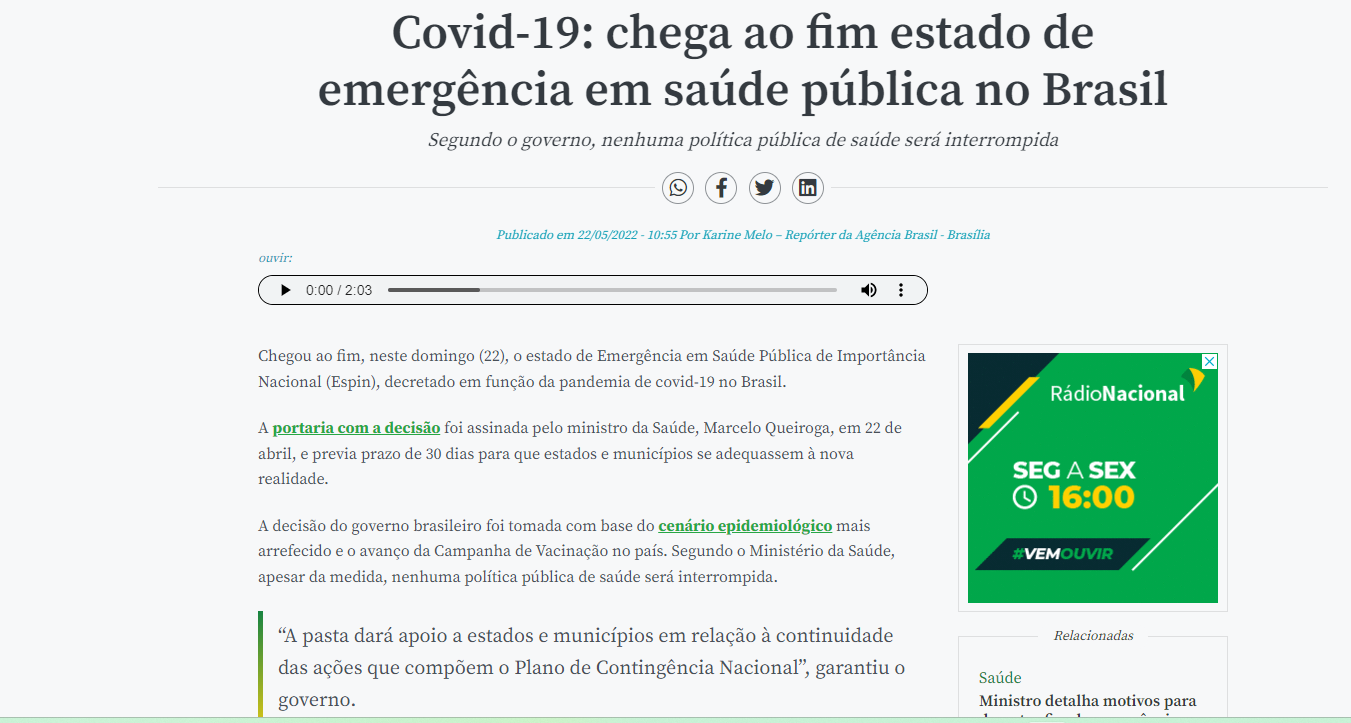


In [74]:
# Criando a coluna "Covid"
dados=dados.assign(Covid='xxx')
inicio_pandemia= pd.to_datetime('2020-03-15')
fim_pandemia=pd.to_datetime('2022-04-22')
for i in range(0,comp_dados):
    if dados['Data'][i]<inicio_pandemia:
        dados['Covid'][i]="Pré-Pandemia"
    elif dados['Data'][i]> fim_pandemia:
        dados['Covid'][i]="Pós-Pandemia"
    else:
        dados['Covid'][i]="Pandemia"
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-03           5856.23            53.56   
5            Sul 2023-07-02           6170.86            56.44   
11           Sul 2023-07-01           6754.27            61.77   
13           Sul 2023-06-30           7630.01            73.05   
19           Sul 2023-06-29           8912.41            85.32   
...          ...        ...               ...              ...   
27013   Nordeste 2005-01-05          11820.00            85.58   
27018   Nordeste 2005-01-04          11285.00            81.71   
27022   Nordeste 2005-01-03          10929.00            79.13   
27027   Nordeste 2005-01-02          10267.00            74.34   
27030   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     5796.86                  53.02  20459.24    17987.46   
5                     5997.03                  54.8

In [75]:
# Exibindo as informações do DataFrame "final", incorporada a coluna "Covid"
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27032 entries, 1 to 27030
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              27032 non-null  object        
 1   Data                    27032 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        27032 non-null  float64       
 3   ENA_Bruta[%MLT]         27032 non-null  float64       
 4   ENA_Armazenavel[MWmed]  27032 non-null  float64       
 5   ENA_Armazenavel[%MLT]   27032 non-null  float64       
 6   EAR_max                 27032 non-null  float64       
 7   EAR[MWmes]              27032 non-null  float64       
 8   EAR[%max]               27032 non-null  float64       
 9   Carga_Diaria[MWmed]     27032 non-null  float64       
 10  CMO_semanal[R$/MWh]     27032 non-null  float64       
 11  CMO_leve[R$/MWh]        27032 non-null  float64       
 12  CMO_media[R$/MWh]       27032 non-null  float6

Portanto, o dataframe "dados" possui todos os valores "não-nulos", sendo as colunas 'Subsistema' e 'Covid' qualitativas.

In [76]:
# Verificando a distribuição das classes (Covid)
dados.groupby('Covid').size()

Covid
Pandemia         3076
Pré-Pandemia    22208
Pós-Pandemia     1748
dtype: int64

Numa etapa futura, que objetivará a predição do CMO, espera-se que o período da pandemia mereça algum tipo de tratamento especial, de modo a evitar vieses incorretos nas saídas dos modelos de Machine Learning, a ser tratado nos próximos Sprints.

In [77]:
# Redefinindo os datasets por subsistema, incorporando a coluna "Covid"
filtro_SE = (dados['Subsistema'] == 'Sudeste')
dados_SE=dados.loc[filtro_SE]
filtro_S = (dados['Subsistema'] == 'Sul')
dados_S=dados.loc[filtro_S]
filtro_NE = (dados['Subsistema'] == 'Nordeste')
dados_NE=dados.loc[filtro_NE]
filtro_N = (dados['Subsistema'] == 'Norte')
dados_N=dados.loc[filtro_N]

In [78]:
print(dados_SE)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-03          24089.43            93.94   
4        Sudeste 2023-07-02          24593.14            95.90   
10       Sudeste 2023-07-01          25148.78            98.07   
12       Sudeste 2023-06-30          24982.82            76.70   
18       Sudeste 2023-06-29          26751.72            82.13   
...          ...        ...               ...              ...   
27015    Sudeste 2005-01-05          45324.00            90.05   
27016    Sudeste 2005-01-04          44388.00            88.19   
27020    Sudeste 2005-01-03          43314.00            86.06   
27025    Sudeste 2005-01-02          43352.00            86.13   
27031    Sudeste 2005-01-01          43952.00            87.32   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]    EAR_max  EAR[MWmes]  \
0                    23822.25                  92.89  204615.33   176452.67   
4                    23651.87                  92

## Visualizações Unimodais

### Histogramas

In [79]:
# Histograma para visualização dos dados de ENA_Bruta[MWmed];ENA_Bruta[%MLT]; EAR[MWmes]; EAR[%max]; Carga_Diaria[MWmed] e CMO_Semanal[R$/MWh]
# Carregando o estilo "seaborn-v0_8"
plt.style.use("seaborn-v0_8")

# Alterando alguns parâmetros gráficos
plt.rc("axes", facecolor="#fafafa", grid = True)
plt.rc("grid", color = "#f0f0f0")
plt.rc("axes", edgecolor="#cccccc", lw=0.1)

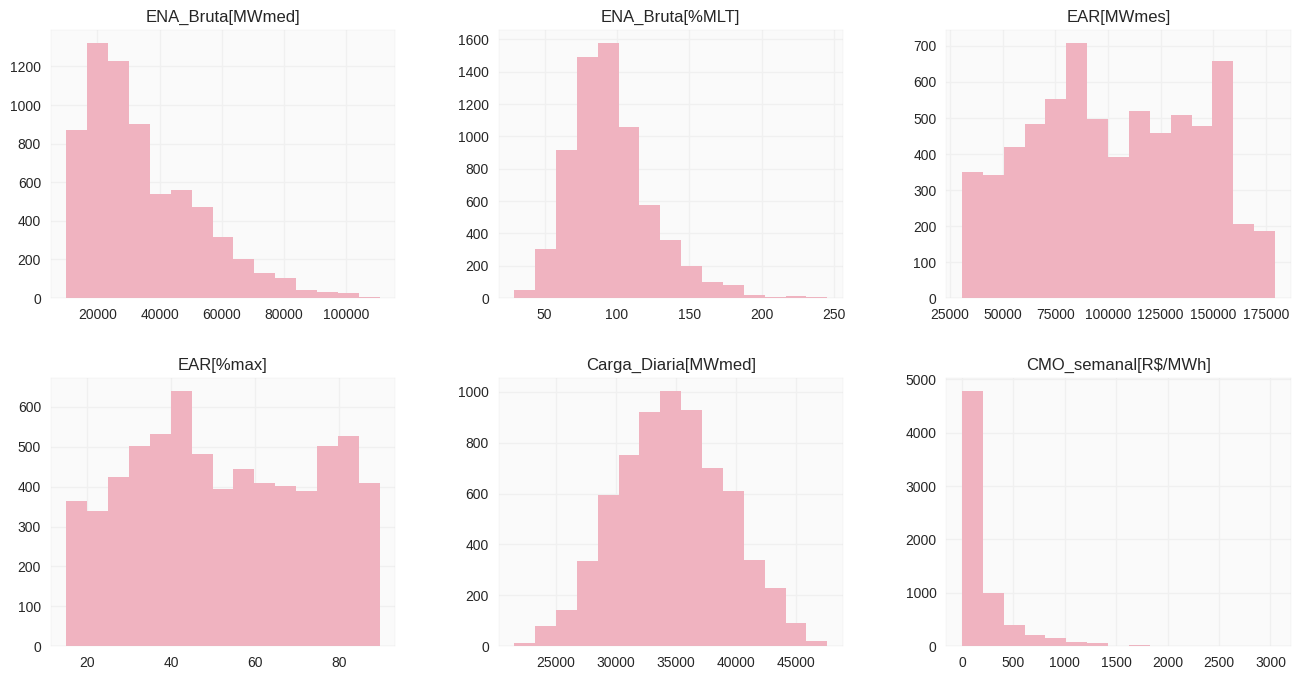

In [80]:
# Histograma Sudeste
dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#F0b3c0")
plt.show()

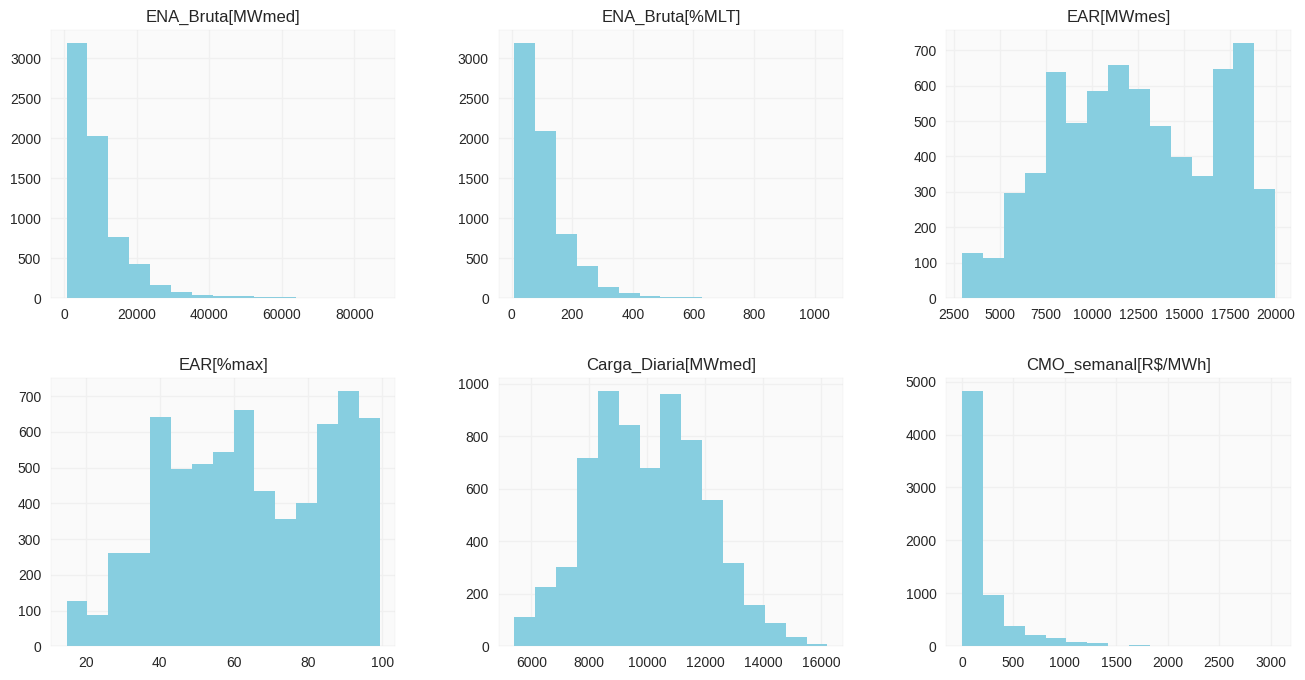

In [81]:
# Histograma Sul
dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#87cee0")
plt.bar_label
plt.show()

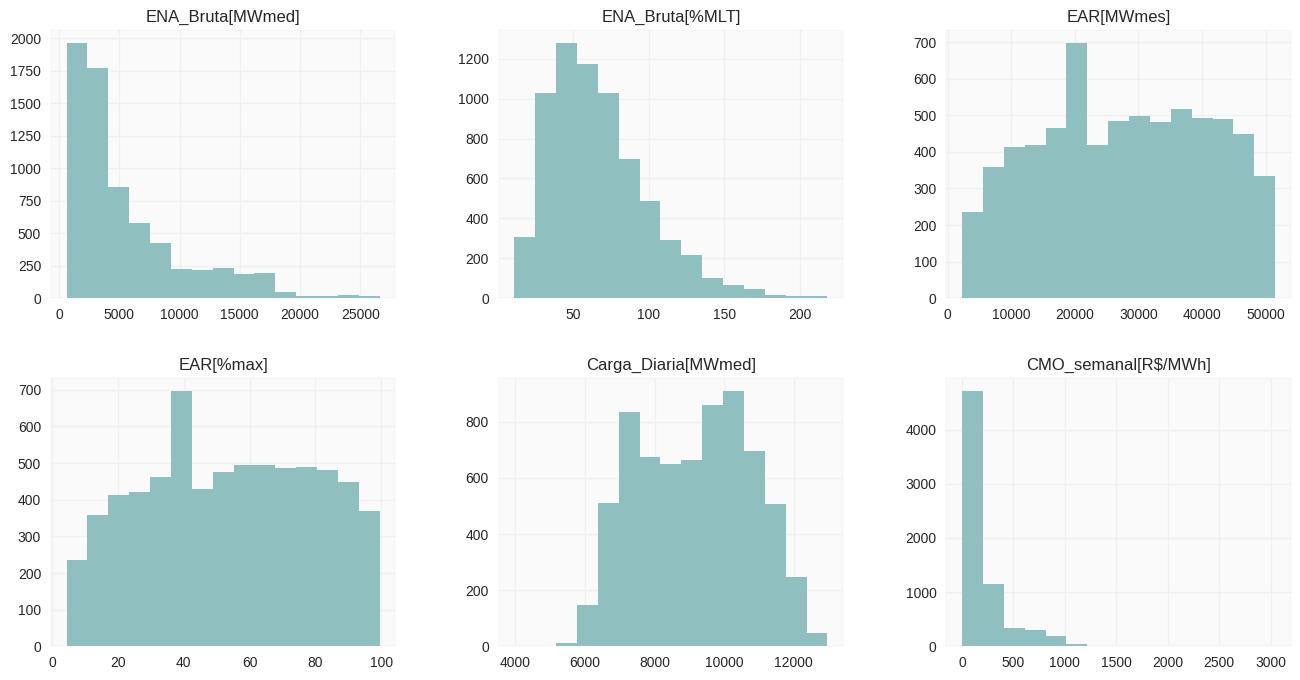

In [82]:
# Histograma Nordeste
dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#8FBfbF")
plt.show()

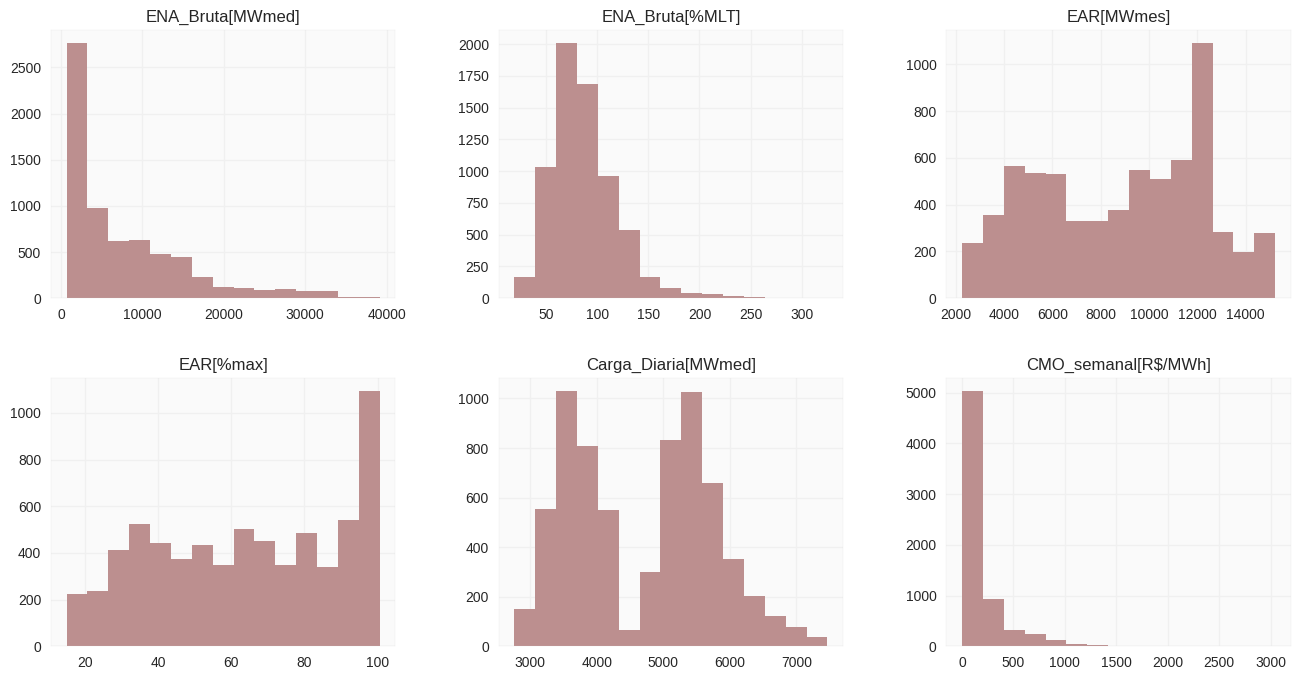

In [83]:
# Histograma Norte
dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15, layout = (2,3), figsize = (16,8), color="#BC8F8F")
plt.show()



> Pela análise dos histogramas, para todos os subsistemas o CMO semanal apresenta assimetria positiva, indicando que a enorme maioria dos valores encontra-se abaixo dos 250 Reais/MWh, embora haja valores extremos, ultrapassando os 3000 R$/MWh, conforme visto nas tabelas com as estatísticas descritivas.


> Em relação ao comportamento da carga diária, para o Sudeste, aproxima-se bastante de uma distribuição normal. Chama a atenção a carga do Norte: provavelmente, esse comportamento "dividido em dois blocos bem definidos" se deve à entrada/saída de algum grande consumidor, que faça com que a ocorrência de valores entre 4 e 5 GWmed seja baixa.


> Em relação aos reservatórios, é interessante observar como, para o subsistema Nordeste, a maior frequência de EAR (%máx) no período está na faixa dos 40%. E que Sudeste e Sul também tiveram reservatórios próximos a esse patamar em um número expressivo de dias.



> Sobre a ENA em % da MLT, todos os subsistemas apresentam assimetria à direita. Para o Sudeste, a maior frequência é próxima dos 80-100% da MLT.









### Boxplot

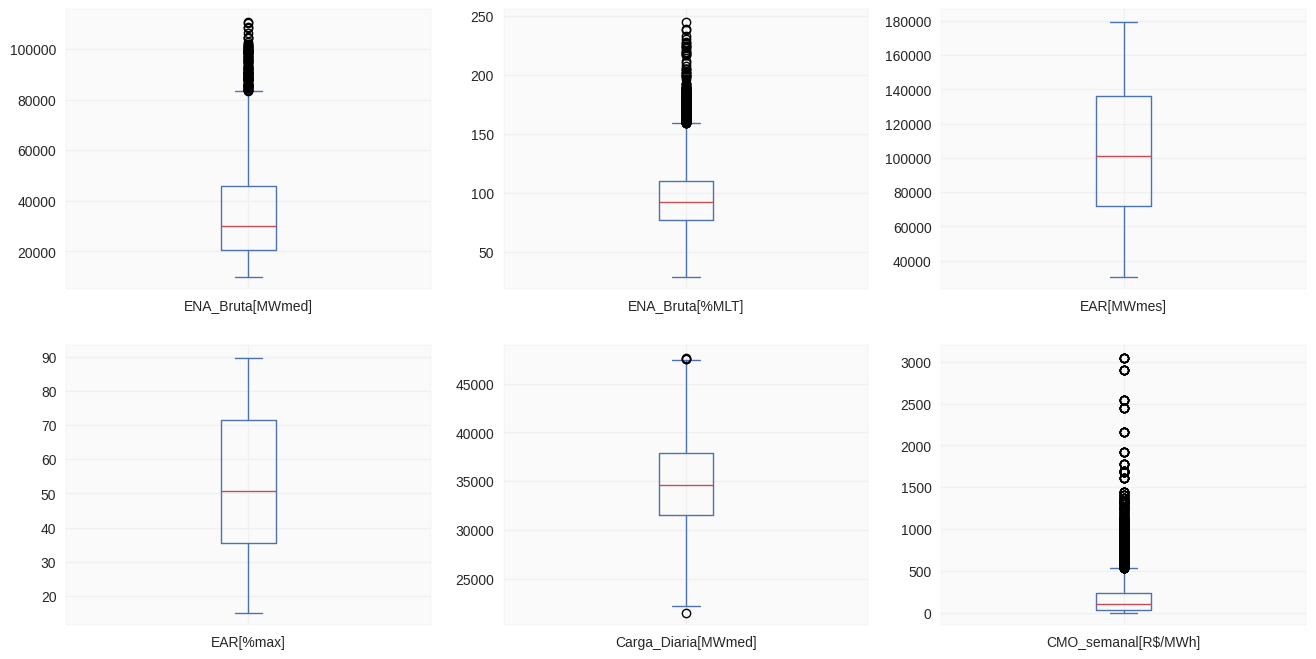

In [84]:
# Boxplot Sudeste
dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

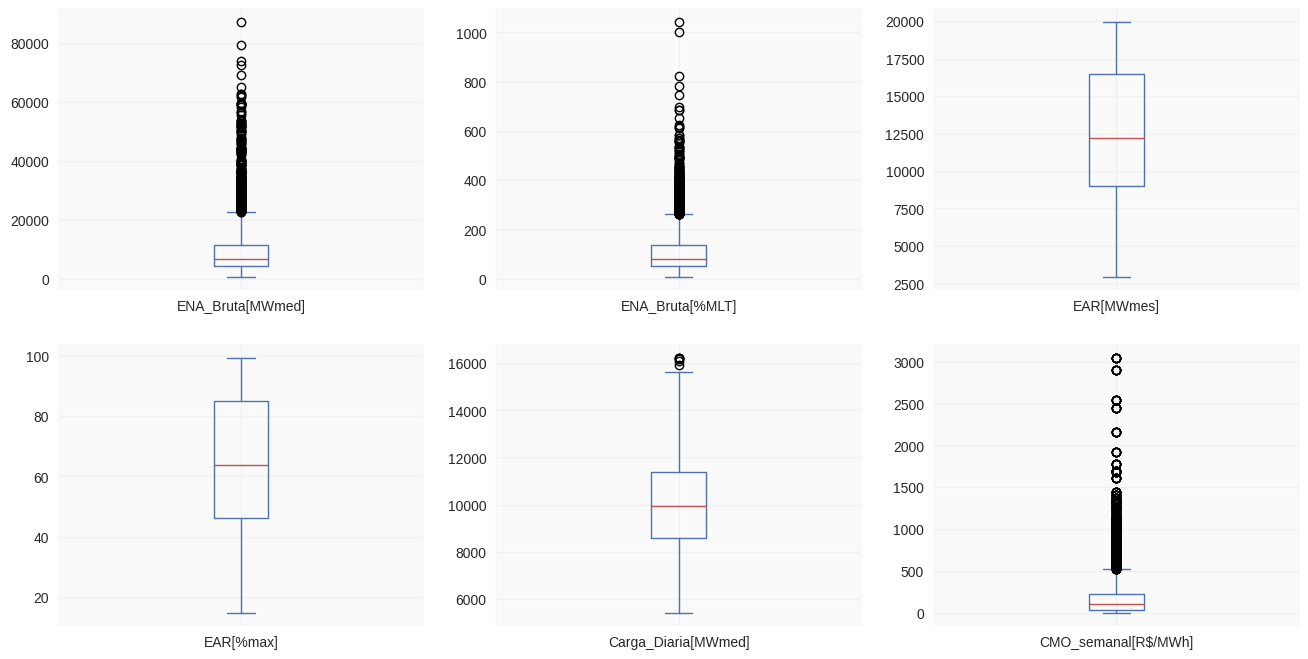

In [85]:
# Boxplot Sul
dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

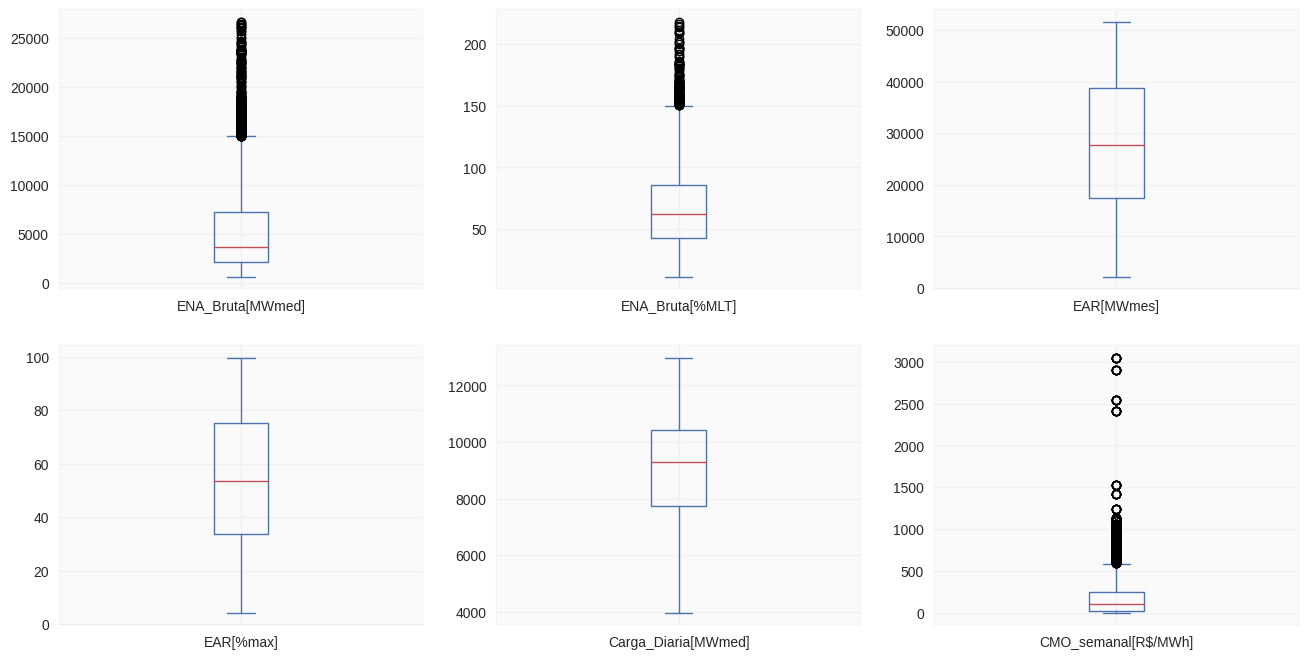

In [86]:
# Boxplot Nordeste
dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

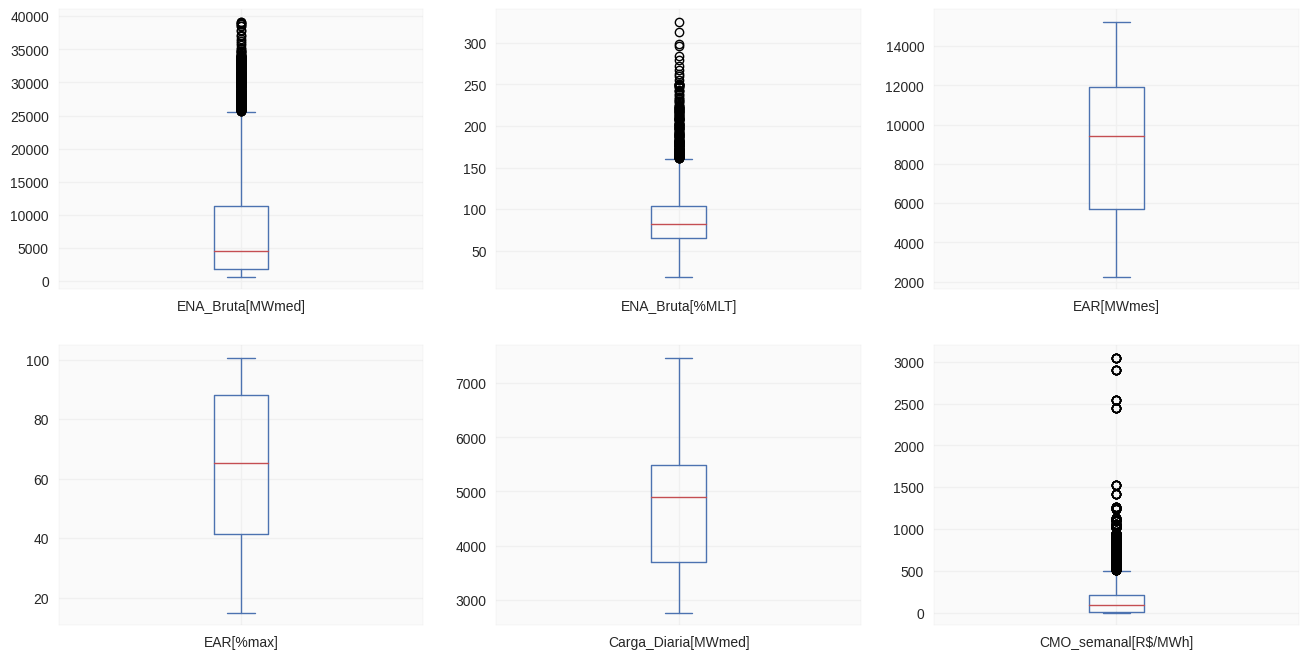

In [87]:
# Boxplot Norte
dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()



> A análise dos gráficos boxplot corrobora as constatações do histograma. Nas plotagens, a linha vermelha representa a mediana (imune a outliers). Para todos os subsistemas, observa-se que, em relação à Energia Armazenada, todos os valores encontram-se dentro dos limites do boxplot (tanto em MWmes quanto em %máximo). Este fato pode ser depreendido do histograma, pelo qual é possível perceber que não há diferenças significativas nas distribuições de probabilidade dos reservatórios, considerando um mesmo subsistema. Fato semelhante ocorre para os gráficos de carga diária. Neste ponto, destaca-se o fato de que, para a região Norte, o valor de P50 (próximo aos 5 GWmed) está bem mais próximo do valor correspondente ao terceiro quartil (P75) do que do primeiro (P25). Isso indica uma distribuição elevada de carga na faixa dos 5 ao 5,5 GWmed no referido subsistema. Para o Sul e Sudeste, alguns poucos valores acima do limite superior do intervalo.

> Em relação à ENA, no entanto, para todos os subsistemas se observam bastante valores fora dos limites do boxplot, característica das distribuições com assimetria à direita. Como destaque, para o Sul, houve uma ocorrência de ENA superior aos 1000% da MLT o que, certamente, configura um evento extremamente atípico em termos meteorológicos/climatológicos.


> Por fim, em relação ao CMO, observa-se que em 50% da amostra, os valores são inferiores a 150 Reais/MWh para os 4 subsistemas. O P75 não chega aos 250 Reais/MWh e o limite da faixa gira em torno dos 500 Reais/MWh. Nas etapas de predição/prescrição, faz-se necessário, portanto, maior atenção aos valores fora do intervalo, provavelmente correspondentes a períodos de grave escassez hídrica, como foi o biênio 2020-2021, quando os baixos valores de ENA e EArm levaram ao CMO de mais de 3000 Reais/MWh.






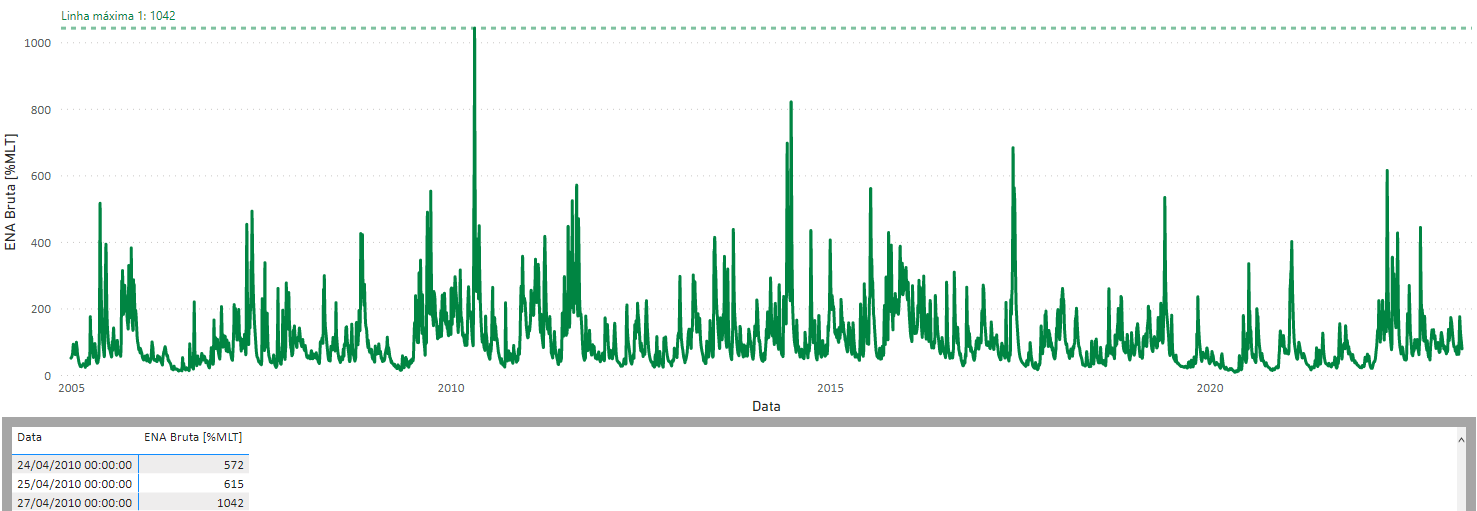
Data de ocorrência do evento de mais de 1000% da MLT na região Sul, correspondente a cerca de 60 GWmed (gráfico elaborado por meio do Power BI).

## Visualizações Multimodais

### Matriz de Correlação

<Axes: >

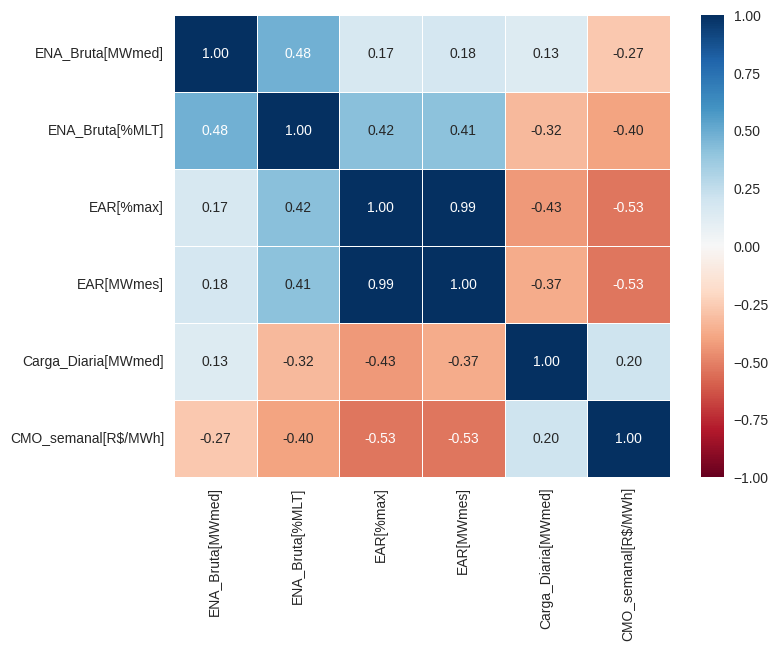

In [88]:
# Matriz de Correlação para o Sudeste
plt.figure(figsize=(8,6))
sns.heatmap(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

<Axes: >

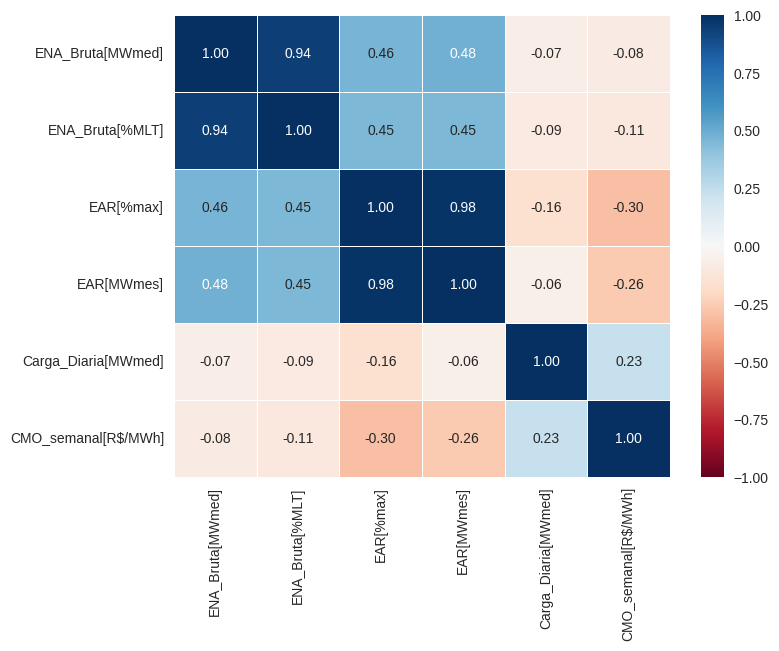

In [89]:
# Matriz de Correlação para o Sul
plt.figure(figsize=(8,6))
sns.heatmap(dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

<Axes: >

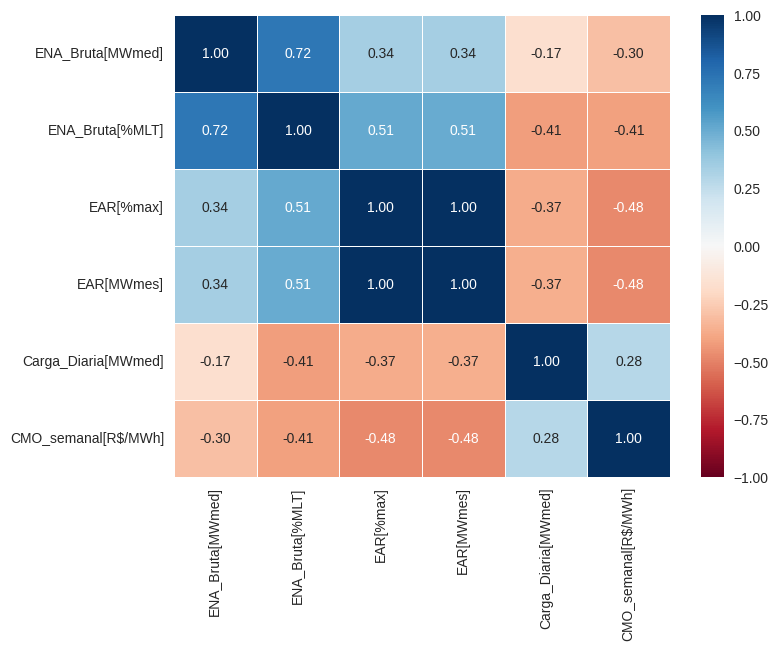

In [90]:
# Matriz de Correlação para o Nordeste
plt.figure(figsize=(8,6))
sns.heatmap(dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

<Axes: >

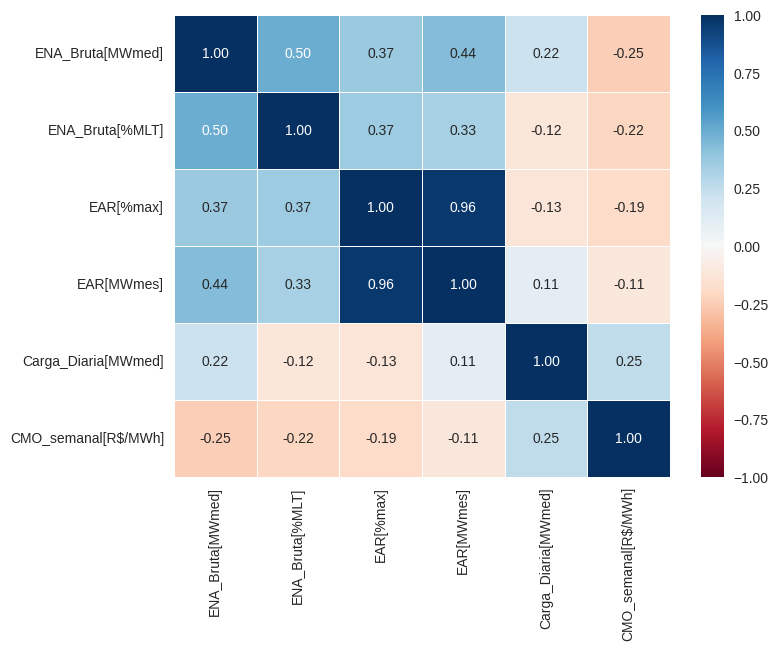

In [91]:
# Matriz de Correlação para o Norte
plt.figure(figsize=(8,6))
sns.heatmap(dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

Conforme analisado anteriormente, considerando todo o horizonte de dados disponível (2005-dias atuais), é possível identificar uma correlação moderada (negativa) do CMO com a Energia Armazenada (em % do volume útil) e com a Energia Natural Afluente (em % da MLT) principalmente para o Sudeste e o Nordeste, que são os subsistemas com maior volume máximo de reservatórios do SIN. Para a carga, a correlação é positiva moderada, em todos os subsistemas, conforme esperado "intuitivamente". É possível constatar ainda que ENA (%MLT) e EArm (%máx) se correlacionam positivamente. Esse comportamento faz sentido, uma vez que na ocorrência de chuvas (e, consequentemente, de elevação da ENA) espera-se que os reservatórios (EArm) também se encham. As políticas operativas, no entanto, podem acabar levando a maiores ou menores deplecionamentos dos reservatórios das usinas hidroelétricas, por fora dos modelos, a depender da conjuntura hidrológica e do balanço energético do Sistema Interligado Nacional.

### Scatter Plot

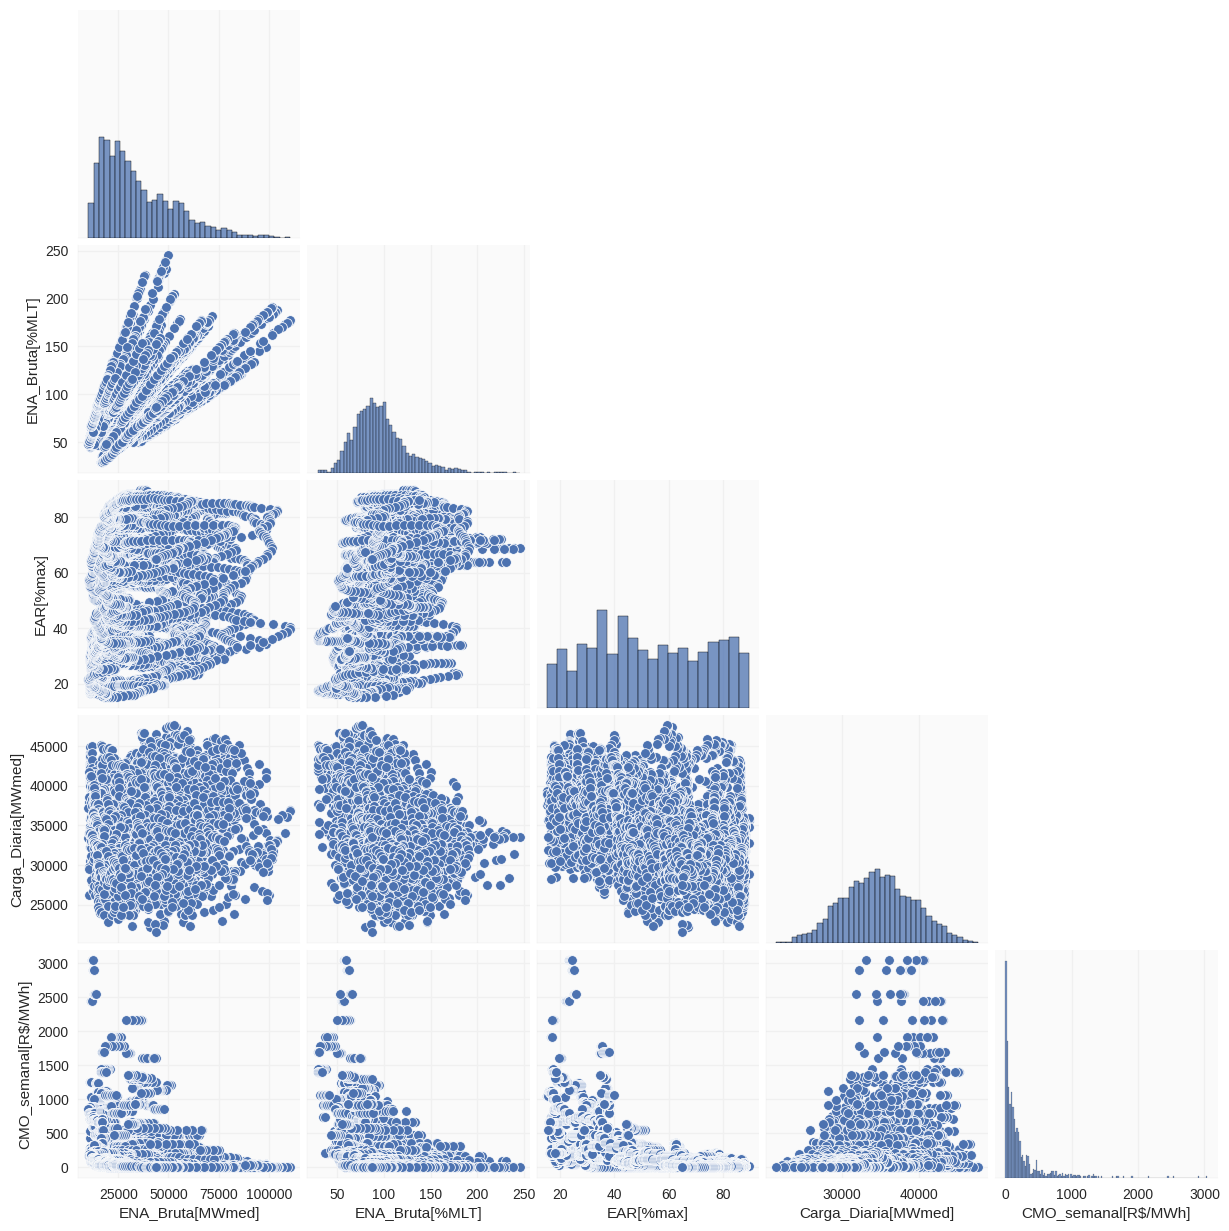

In [92]:
# Faremos a análise apenas para o subsistema sudeste, por ser o mais relevante para o SIN
# Scatter Plot com Seaborn - Sudeste
sns.pairplot(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']], corner=True)

Pela avaliação do scatter-plot, podemos observar como os maiores valores de CMO semanal ocorrem para valores de ENA Bruta inferiores a 75% da MLT e para reservatórios abaixo dos 40% do volume útil no Sudeste. É possível observar também que o CMO de 0 R$/MWh nunca ocorreu em casos de ENA diária inferior a 50% da MLT no Sudeste. Um outro destaque é o fato de os maiores valores de CMO não terem ocorrido para valores mínimos de ENA em % da MLT (e sim próximo aos 60%), mas, para ENAs muito baixas em termos absolutos (MWmed). Isto nos leva a crer que esses Custos muito elevados se deram em algum mês de MLT mais baixa (ou seja, de valores históricos de chuva mais baixos, pela sazonalidade/climatologia. Provavelmente, entre junho e novembro, meses do chamado "período seco"). Além disso, para reservatórios superiores a 50%-55%, o CMO não ultrapassou os 500 Reais/MWh que, como vimos no Boxplot, é o limite superior do mesmo. Em relação à carga, à exceção de valores outlier de CMO, o comportamento da curva Carga x CMO parece ter uma tendência de distribuição normal, para a qual valores mais elevados de CMO ocorrem em cargas intermediárias, entre 30 e 40 GWmed. Esse comportamento não é intuitivo, a princípio. Porém, como pode ser visto no gráfico de ENA Bruta (MWmed) x Carga, os maiores valores de ENA ocorreram para cargas de aproximadamente 35 GWmed e isso poderia explicar o comportamento do CMO (embora essa relação ENA x Carga possa ser uma coincidência em função da pandemia - menor carga e El Niño - condições climáticas - menor ENA). Para trabalhos futuros, fazem-se necessárias avaliações mais detalhadas a respeito.

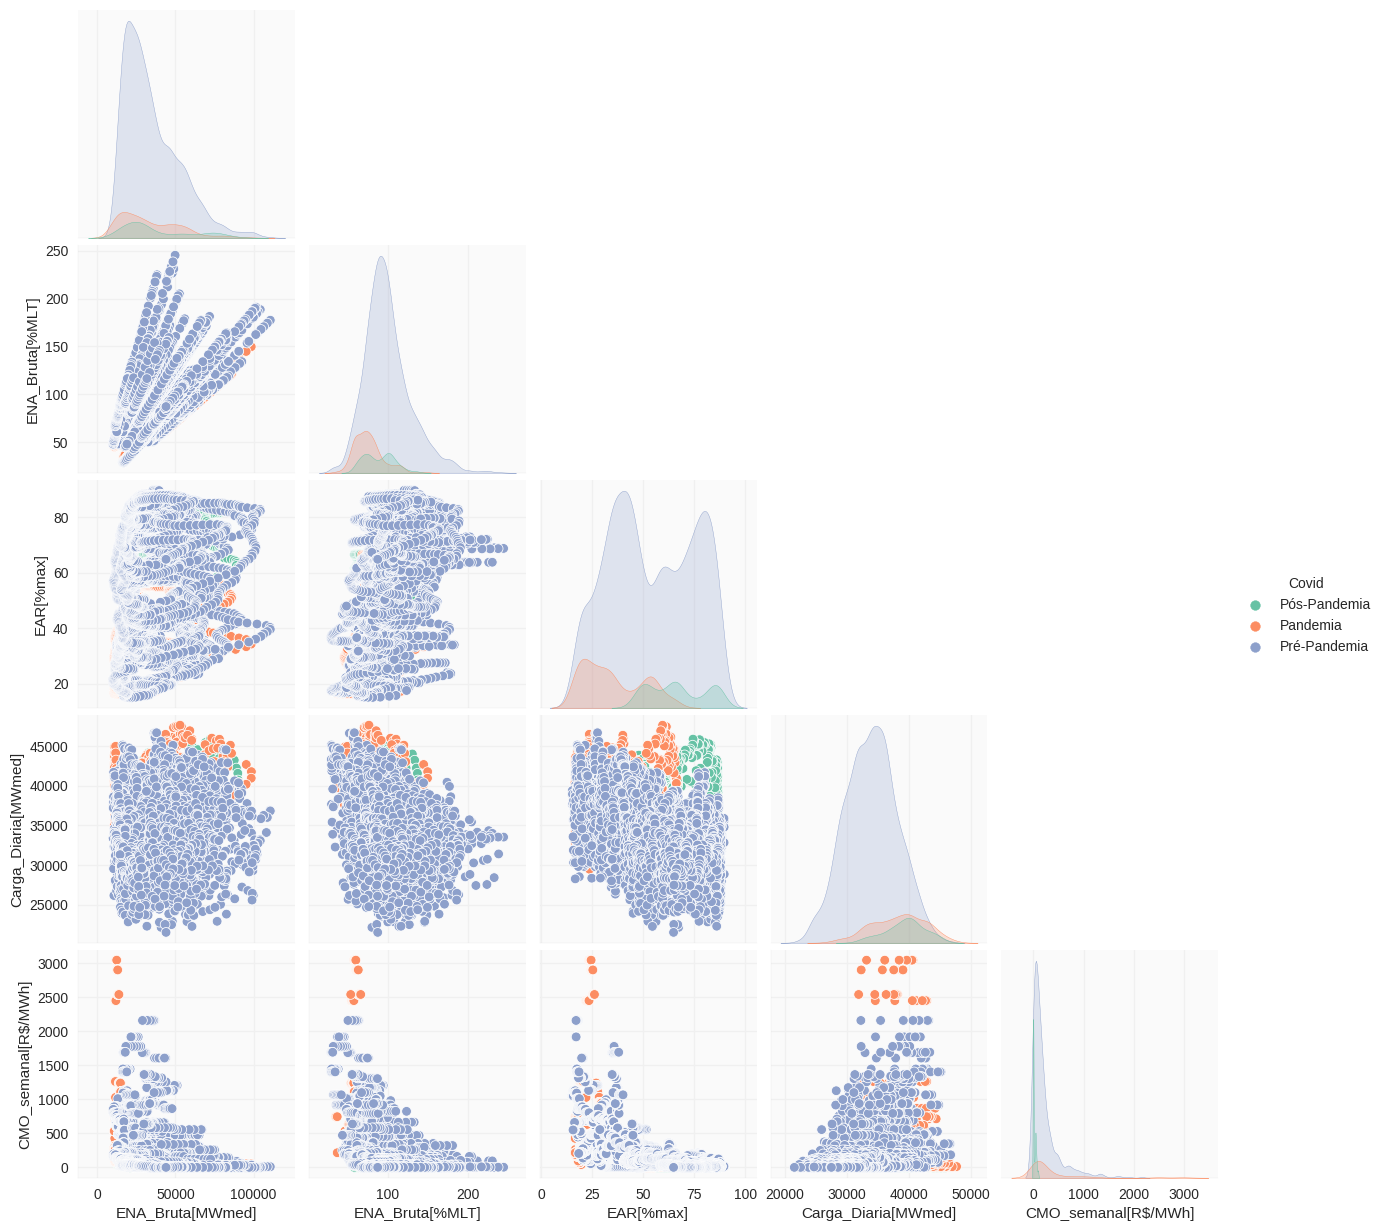

In [93]:
# Scatter Plot considerando a variável qualitativa referente à pandemia de Covid-19
# Faremos a análise apenas para o subsistema sudeste, por ser o mais relevante para o SIN
sns.pairplot(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]','Covid']], hue = "Covid", height = 2.5, corner=True, palette="Set2")

A principal interferência da pandemia de Covid-19 nas grandezas avaliadas diz respeito à carga. Embora, coincidentemente (mas sem nenhum tipo de relação causal), os valores de ENA (em MWmed e em % da MLT) tenham tido uma distribuição mais assimétrica à direita no período da pandemia do que no período anterior a ela. É necessário, em análises futuras (e no treinamento dos modelos de ML) cautela neste aspecto, para que os algoritmos não indiquem correlações indevidas entre a pandemia e a ENA. Em relação à carga, durante a pandemia (e no pós), o que enxergamos é um deslocamento da curva para uma assimetria mais à esquerda. Para análises futuras, é interessante avaliar os anos imediatamente anteriores à pandemia (talvez encurtar o horizonte, neste caso, por exemplo), para tentar entender melhor os efeitos. Além disso, no durante e pós-pandemia observa-se um desvio-padrão maior (da carga) em comparação aos anos prévios. Sobre a correlação com o CMO, observamos que os maiores valores de CMO registrados ocorreram durante a pandemia, mesmo para cargas intermediárias que, fora da pandemia, levaram o custo no máximo a 70% dos 3000 Reais/MWh). E este fato provavelmente se explica pelos valores mais severos de ENA e EArm no intervalo de 2020 a 2022.

## Avaliações Temporais no Power BI

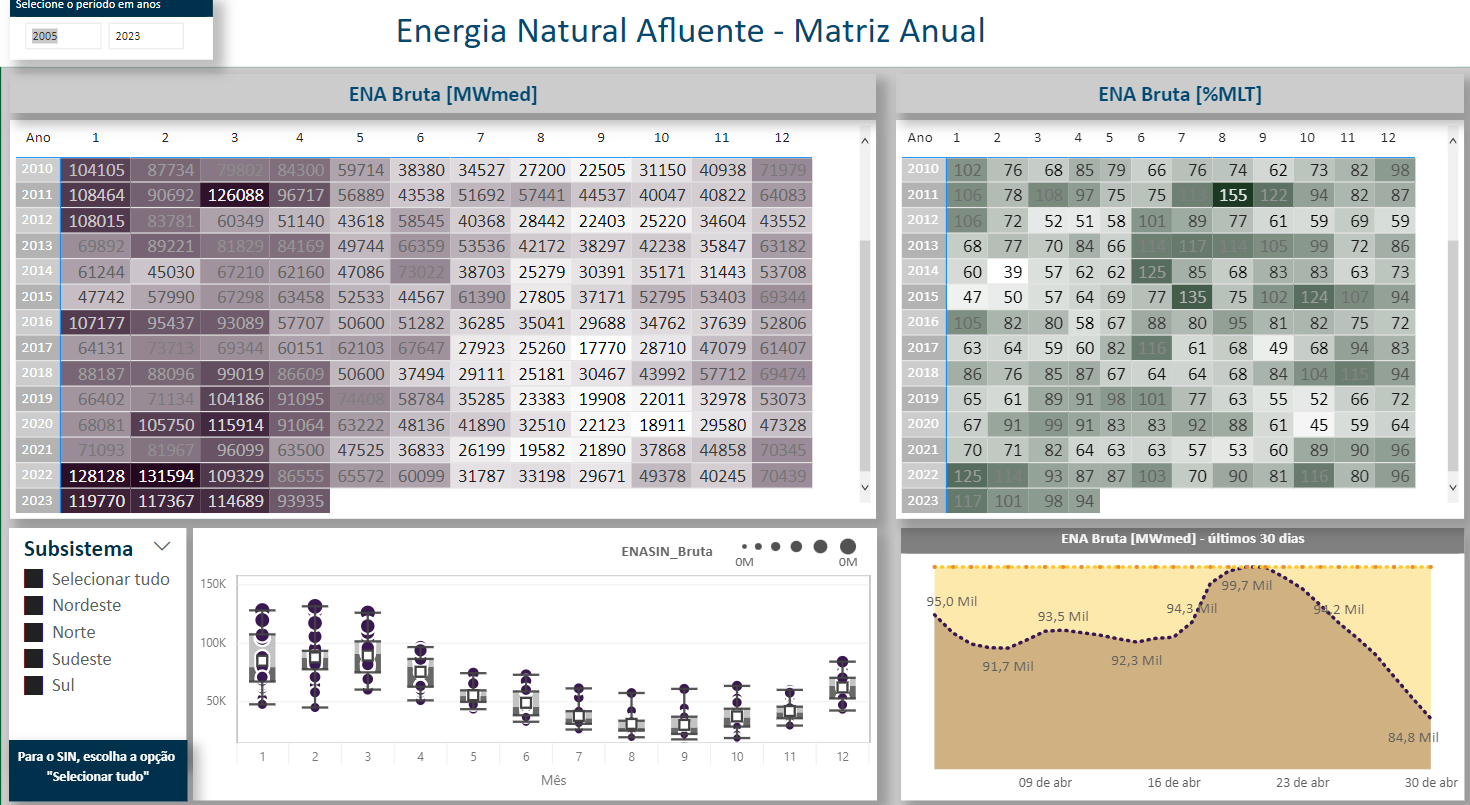

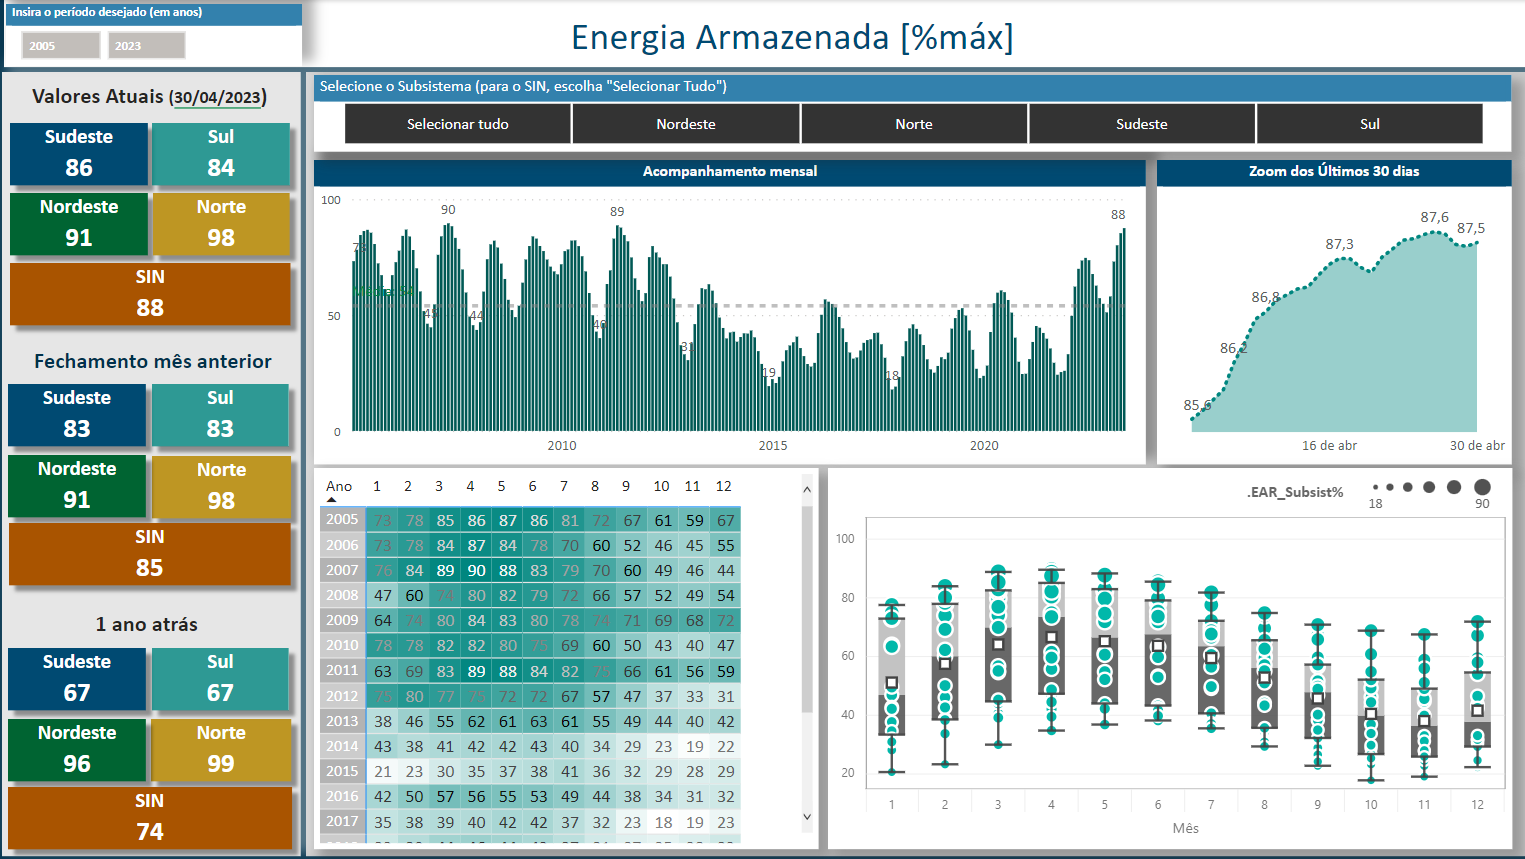

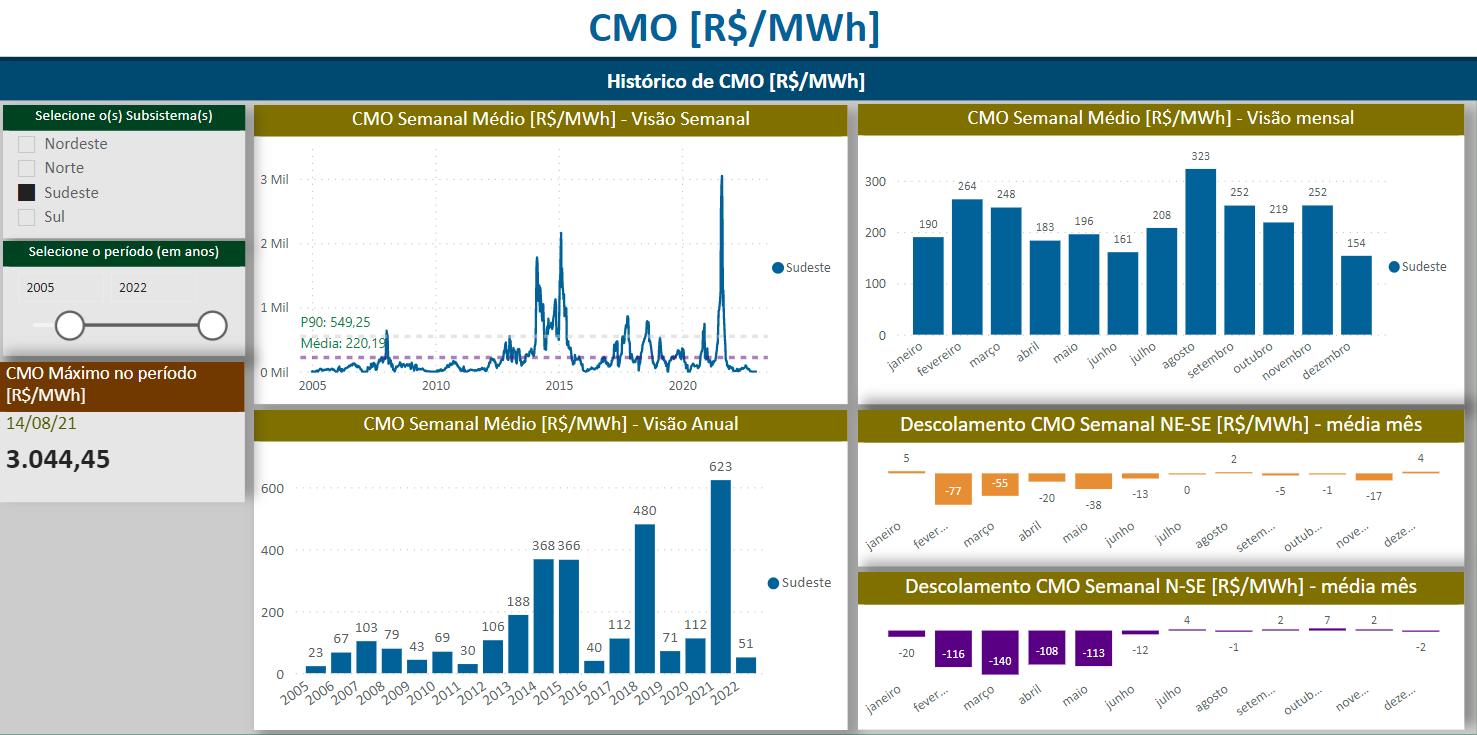

Os dados obtidos a partir da Área de Dados Abertos do ONS foram importados no Power BI (via Power Query) e, em seguida, foram gerados os dashboard acima. Pelas visualizações, pode-se concluir, por exemplo, que: desde 2011, o mês de abril não registrava ENA (% da MLT) tão alta. Além disso, pelo boxplot de ENA é possível identificar a sazonalidade do período chuvoso/seco no Brasil, de modo que dezembro a abril são os meses de maior mediana (período úmido). Em relação ao histórico recente, observa-se uma queda de mais de 10 GWmed de ENA no SIN entre o final de março e o final de abril o que é, de certa forma, esperado pela climatologia dos referidos meses. Apesar da redução da ENA (em termos absolutos) os reservatórios do SIN sofreram uma elevação no último mês. Quando comparados ao mesmo período de 2022 (30/04/23 vs 30/04/22), a crescente é muito expressiva, principalmente no Sul e no Sudeste. Podemos perceber que o enchimento/deplecionamento dos reservatórios tem um comportamento cíclico ao longo de um ano e que, desde 2011, não observávamos condições tão favoráveis de energia armazenada quanto atualmente. Em relação ao CMO médio no decorrer dos anos, observa-se que, de fato, 2011 teve valores baixíssimos do custo de operação médio. Também é possível observar que em 2021, quando as ENAs ficaram muito baixas, o preço médio anual foi o maior do histórico e que basta um ano favorável ou desfavorável em termos de chuva para alterar a tendência de CMO do ano anterior. Em relação aos valores médios nos meses, observa-se que agosto (mês de menor MLT no Sudeste) é o de maior CMO médio, ao passo que dezembro (início do período úmido), o de menor. Em relação aos valores por subsistema, observa-se que nos meses chuvosos, dentro do horizonte analisado, em geral o CMO do Nordeste e do Norte foi menor que o do Sudeste. Este aspecto está diretamente relacionado à capacidade de fluxo de energia entre os subsistemas e, considerando ampliações e reforços na transmissão, pode não ser mais replicável daqui em diante. Este aspecto não está explícito pelos dados do presente trabalho mas, em etapas futuras, faz-se pertinente a inclusão.


# **Seção IV: Pré-Processamento de Dados - Parte 2**


> Ao longo das seções/etapas anteriores, já realizamos várias atividades de pré-processamento de dados, de modo a deixar nosso DataFrame mais "enxuto", menos "redundante" e mais adequado para aplicação de Modelos de Machine Learning. Neste momento, iremos reduzir ainda mais a dimensionalidade e realizar algumas transformações numéricas.



## Redução da Dimensionalidade

In [94]:
# Reduzindo a dimensionalidade do dataset dados, excluindo as colunas de CMO por patamar
dados=dados[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_SE=dados_SE[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_S=dados_S[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_NE=dados_NE[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_N=dados_N[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]',]]

# Avaliando as 20 primeiras linhas do dataset dados
dados.head(20)

Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1  2023-07-03        Sul           5856.23            53.56   
5  2023-07-02        Sul           6170.86            56.44   
11 2023-07-01        Sul           6754.27            61.77   
13 2023-06-30        Sul           7630.01            73.05   
19 2023-06-29        Sul           8912.41            85.32   
21 2023-06-28        Sul          10456.86           100.11   
25 2023-06-27        Sul          12540.68           120.06   
29 2023-06-26        Sul          15461.61           148.02   
35 2023-06-25        Sul          18802.16           180.00   
37 2023-06-24        Sul          19876.21           190.28   
41 2023-06-23        Sul          15158.23           145.12   
45 2023-06-22        Sul           8642.23            82.74   
50 2023-06-21        Sul           9165.50            87.75   
53 2023-06-20        Sul          10204.31            97.69   
57 2023-06-19        Sul          11748.50           112.47   
61 2023-06-18        Sul          13721.10           131.36   
67 2023-06-17        Sul          15497.13           148.36   
69 2023-06-16        Sul          14897.60           142.62   
73 2023-06-15        Sul           9175.31            87.84   
77 2023-06-14        Sul           6060.48            58.02   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[%max]  \
1                  5796.86                  53.02  20459.24      87.92   
5                  5997.03                  54.85  20459.24      88.36   
11                 6690.65                  61.19  20459.24      88.42   
13                 7528.50                  72.07  20459.24      88.31   
19                 8117.23                  77.71  20459.24      88.69   
21                 7750.04                  74.19  20459.24      88.88   
25                 8711.49                  83.40  20459.24      88.69   
29                 8165.07                  78.17  20459.24      88.63   
35                 7884.47                  75.48  20459.24      88.85   
37                 9031.56                  86.46  20459.24      88.50   
41                 8709.73                  83.38  20459.24      87.32   
45                 7011.39                  67.12  20459.24      86.01   
50                 7116.27                  68.13  20459.24      85.75   
53                 8726.05                  83.54  20459.24      85.67   
57                 8195.27                  78.46  20459.24      85.12   
61                10546.01                 100.96  20459.24      84.89   
67                13598.06                 130.18  20459.24      84.11   
69                12618.48                 120.80  20459.24      82.90   
73                 8947.95                  85.66  20459.24      81.33   
77                 5800.91                  55.53  20459.24      80.43   

    EAR[MWmes]  Carga_Diaria[MWmed]         Covid  CMO_semanal[R$/MWh]  
1     17987.46              9695.06  Pós-Pandemia                  0.0  
5     18077.75              9695.06  Pós-Pandemia                  0.0  
11    18089.04             10884.16  Pós-Pandemia                  0.0  
13    18067.61             12594.56  Pós-Pandemia                  0.0  
19    18146.06             12230.42  Pós-Pandemia                  0.0  
21    18185.00             12324.42  Pós-Pandemia                  0.0  
25    18144.35             12097.43  Pós-Pandemia                  0.0  
29    18133.57             11717.31  Pós-Pandemia                  0.0  
35    18177.75              8993.10  Pós-Pandemia                  0.0  
37    18106.51             10182.21  Pós-Pandemia                  0.0  
41    17864.58             12567.50  Pós-Pandemia                  0.0  
45    17597.21             12967.64  Pós-Pandemia                  0.0  
50    17544.79             12720.54  Pós-Pandemia                  0.0  
53    17528.37             12324.70  Pós-Pandemia                  0.0  
57    17414.84             11979.16

In [95]:
# Confirmando novamente a ausência de dados faltantes
dados.isnull().sum()

Data                      0
Subsistema                0
ENA_Bruta[MWmed]          0
ENA_Bruta[%MLT]           0
ENA_Armazenavel[MWmed]    0
ENA_Armazenavel[%MLT]     0
EAR_max                   0
EAR[%max]                 0
EAR[MWmes]                0
Carga_Diaria[MWmed]       0
Covid                     0
CMO_semanal[R$/MWh]       0
dtype: int64

In [96]:
# Exibindo as dimensões de cada dataset
print("SIN:")
print(dados.shape)
print("Sudeste:")
print(dados_SE.shape)
print("Sul:")
print(dados_S.shape)
print("Nordeste:")
print(dados_NE.shape)
print("Norte:")
print(dados_N.shape)

SIN:
(27032, 12)
Sudeste:
(6758, 12)
Sul:
(6758, 12)
Nordeste:
(6758, 12)
Norte:
(6758, 12)


## Preparação para os Algoritmos de ML

A Normalização e a padronização são técnicas frequentemente aplicadas na etapa de preparação dos dados, com o objetivo de colocá-los em um intervalo de valores comuns. Não são técnicas obrigatórias para todos os algoritmos de Machine Learning mas podem impactar na acurácia do modelo a ser utilizado.

Alterando os dados da coluna 'Covid' de qualitativos (categóricos) para codificação ordinal, de modo que "Pré-Pandemia"=0; "Pandemia"=1 e "Pós-Pandemia"=2

In [97]:
# Armazenando os datasets com a coluna 'Covid' original
dados_pandemia=dados
dados_pandemia_SE=dados_SE
dados_pandemia_S=dados_S
dados_pandemia_NE=dados_NE
dados_pandemia_N=dados_N

In [98]:
# Aplicando Ordinal Encoding
dados['Covid']=dados['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_SE['Covid']=dados_SE['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_S['Covid']=dados_S['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_NE['Covid']=dados_NE['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_N['Covid']=dados_N['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados.head(20)

Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1  2023-07-03        Sul           5856.23            53.56   
5  2023-07-02        Sul           6170.86            56.44   
11 2023-07-01        Sul           6754.27            61.77   
13 2023-06-30        Sul           7630.01            73.05   
19 2023-06-29        Sul           8912.41            85.32   
21 2023-06-28        Sul          10456.86           100.11   
25 2023-06-27        Sul          12540.68           120.06   
29 2023-06-26        Sul          15461.61           148.02   
35 2023-06-25        Sul          18802.16           180.00   
37 2023-06-24        Sul          19876.21           190.28   
41 2023-06-23        Sul          15158.23           145.12   
45 2023-06-22        Sul           8642.23            82.74   
50 2023-06-21        Sul           9165.50            87.75   
53 2023-06-20        Sul          10204.31            97.69   
57 2023-06-19        Sul          11748.50           112.47   
61 2023-06-18        Sul          13721.10           131.36   
67 2023-06-17        Sul          15497.13           148.36   
69 2023-06-16        Sul          14897.60           142.62   
73 2023-06-15        Sul           9175.31            87.84   
77 2023-06-14        Sul           6060.48            58.02   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[%max]  \
1                  5796.86                  53.02  20459.24      87.92   
5                  5997.03                  54.85  20459.24      88.36   
11                 6690.65                  61.19  20459.24      88.42   
13                 7528.50                  72.07  20459.24      88.31   
19                 8117.23                  77.71  20459.24      88.69   
21                 7750.04                  74.19  20459.24      88.88   
25                 8711.49                  83.40  20459.24      88.69   
29                 8165.07                  78.17  20459.24      88.63   
35                 7884.47                  75.48  20459.24      88.85   
37                 9031.56                  86.46  20459.24      88.50   
41                 8709.73                  83.38  20459.24      87.32   
45                 7011.39                  67.12  20459.24      86.01   
50                 7116.27                  68.13  20459.24      85.75   
53                 8726.05                  83.54  20459.24      85.67   
57                 8195.27                  78.46  20459.24      85.12   
61                10546.01                 100.96  20459.24      84.89   
67                13598.06                 130.18  20459.24      84.11   
69                12618.48                 120.80  20459.24      82.90   
73                 8947.95                  85.66  20459.24      81.33   
77                 5800.91                  55.53  20459.24      80.43   

    EAR[MWmes]  Carga_Diaria[MWmed]  Covid  CMO_semanal[R$/MWh]  
1     17987.46              9695.06      2                  0.0  
5     18077.75              9695.06      2                  0.0  
11    18089.04             10884.16      2                  0.0  
13    18067.61             12594.56      2                  0.0  
19    18146.06             12230.42      2                  0.0  
21    18185.00             12324.42      2                  0.0  
25    18144.35             12097.43      2                  0.0  
29    18133.57             11717.31      2                  0.0  
35    18177.75              8993.10      2                  0.0  
37    18106.51             10182.21      2                  0.0  
41    17864.58             12567.50      2                  0.0  
45    17597.21             12967.64      2                  0.0  
50    17544.79             12720.54      2                  0.0  
53    17528.37             12324.70      2                  0.0  
57    17414.84             11979.16      2                  0.0  
61    17367.77              8869.09      2                  0.0  
67    17

In [108]:
# Adicionando uma coluna referente ao dia da semana correspondente à data

dados=dados.assign(Dia_da_semana=1)
for i in range(0,comp_dados):
    dados['Dia_da_semana'][i]=dados['Data'][i].weekday() #Por esta lógica, as segundas recebem o índice 0  e os domingos, 6
# Para retratar semanas operativas, que vão do sábado à sexta da semana seguinte, é interessante que os sábados correspondam ao 0, domingos ao 1...sexta-feira corresponda a 6:
    if dados['Dia_da_semana'][i]<5:
       dados['Dia_da_semana'][i]=dados['Dia_da_semana'][i]+2
    else:
       dados['Dia_da_semana'][i]=dados['Dia_da_semana'][i]-5
print(dados)

            Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1     2023-07-03        Sul           5856.23            53.56   
5     2023-07-02        Sul           6170.86            56.44   
11    2023-07-01        Sul           6754.27            61.77   
13    2023-06-30        Sul           7630.01            73.05   
19    2023-06-29        Sul           8912.41            85.32   
...          ...        ...               ...              ...   
27013 2005-01-05   Nordeste          11820.00            85.58   
27018 2005-01-04   Nordeste          11285.00            81.71   
27022 2005-01-03   Nordeste          10929.00            79.13   
27027 2005-01-02   Nordeste          10267.00            74.34   
27030 2005-01-01   Nordeste          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[%max]  \
1                     5796.86                  53.02  20459.24      87.92   
5                     5997.03                  54.85 

A variável que pretendemos predizer é o CMO Semanal Médio. Para tal, dividiremos nosso dataset por cada um dos subsistemas, considerando os subconjuntos de treino, teste e validação.

Por se tratar de uma variável numérica, contínua, utilizaremos algoritmos de Machine Learning destinados a problemas de regressão.

In [198]:
# Separando cada dataset (por subsistema) em componentes de "entrada" e "saída"
# A variável de interesse é o CMO Semanal Médio [R$/MWh]

# SIN
X= dados.values[:,2:10]
y=dados.values[:,9]
# Sudeste
X_SE= dados_SE.values[:,2:10]
y_SE=dados_SE.values[:,9]
# Sul
X_S= dados_S.values[:,2:10]
y_S=dados_S.values[:,9]
# Nordeste
X_NE= dados_NE.values[:,2:10]
y_NE=dados_NE.values[:,9]
# Norte
X_N= dados_N.values[:,2:10]
y_N=dados_N.values[:,9]

Neste momento, realizaremos a análise apenas para o subsistema Sudeste, normalizando e padronizando os dados quantitativos do dataset dados_SE

### Normalização dos Dados

In [ ]:
# Normalizando os dados
rescaledX_norm = MinMaxScaler().fit_transform(X_SE)

# Exibindo os dados transformados
print("Dados Originais: \n\n", dados_SE.values)
print("\nDados Normalizados (não inclui a coluna class): \n\n", rescaledX_norm)

Dados Originais: 

 [[Timestamp('2023-05-02 00:00:00') 'Sudeste' 48473.26 ... 2 0.0 2]
 [Timestamp('2023-05-01 00:00:00') 'Sudeste' 49685.99 ... 2 0.0 2]
 [Timestamp('2023-04-30 00:00:00') 'Sudeste' 51014.51 ... 2 0.0 2]
 ...
 [Timestamp('2005-01-03 00:00:00') 'Sudeste' 43314.0 ... 0 0.0 0]
 [Timestamp('2005-01-02 00:00:00') 'Sudeste' 43352.0 ... 0 0.0 0]
 [Timestamp('2005-01-01 00:00:00') 'Sudeste' 43952.0 ... 0 0.0 0]]

Dados Normalizados (não inclui a coluna class): 

 [[0.38173198 0.42759291 0.34532354 ... 0.95355705 0.73551536 1.        ]
 [0.39376876 0.44166242 0.29913266 ... 0.95449664 0.5116954  1.        ]
 [0.4069548  0.29675568 0.30133153 ... 0.95422819 0.49998257 1.        ]
 ...
 [0.33052446 0.2638034  0.43522669 ... 0.66926174 0.22828458 0.        ]
 [0.33090162 0.26412737 0.40982741 ... 0.66818792 0.03839024 0.        ]
 [0.33685684 0.26963484 0.40314271 ... 0.66657718 0.         0.        ]]


### Padronização dos Dados

In [ ]:
# Padronizando os dados
rescaledX_padr = StandardScaler().fit_transform(X_SE)

# Exibindo os dados transformados
print("Dados Originais: \n\n", dados_SE.values)
print("\nDados Padronizados (não inclui a coluna class): \n\n", rescaledX_padr)

Dados Originais: 

 [[Timestamp('2023-05-02 00:00:00') 'Sudeste' 48473.26 ... 2 0.0 2]
 [Timestamp('2023-05-01 00:00:00') 'Sudeste' 49685.99 ... 2 0.0 2]
 [Timestamp('2023-04-30 00:00:00') 'Sudeste' 51014.51 ... 2 0.0 2]
 ...
 [Timestamp('2005-01-03 00:00:00') 'Sudeste' 43314.0 ... 0 0.0 0]
 [Timestamp('2005-01-02 00:00:00') 'Sudeste' 43352.0 ... 0 0.0 0]
 [Timestamp('2005-01-01 00:00:00') 'Sudeste' 43952.0 ... 0 0.0 0]]

Dados Padronizados (não inclui a coluna class): 

 [[ 0.74323101  0.88520847  0.26457726 ...  1.62997655  1.33783488
   3.3075294 ]
 [ 0.8093511   0.99132178  0.02319005 ...  1.63335269  0.04668885
   3.3075294 ]
 [ 0.88178425 -0.10157552  0.03468102 ...  1.63238808 -0.02087876
   3.3075294 ]
 ...
 [ 0.46193943 -0.35010406  0.73439876 ...  0.60845383 -1.58821796
  -0.4231565 ]
 [ 0.46401125 -0.34766067  0.60166561 ...  0.60459539 -2.68365792
  -0.4231565 ]
 [ 0.49672427 -0.30612289  0.56673229 ...  0.59880773 -2.90511898
  -0.4231565 ]]


# **Seção V: Conclusão**

O presente trabalho teve como objetivo a obtenção, tratamento e análise dos dados históricos de Energia Natural Afluente, Energia Armazenada, Demanda Elétrica e Custo Marginal da Operação, a partir dos dados diários por subsistema publicados pelo Operador Nacional do Sistema Elétrico. Puderam-se observar os comportamentos das referidas grandezas no período de 2005 a abril/2023, tanto ao longo do tempo, quanto em termos de distribuição (unimodal). Além disso, também foi possível avaliar as correlações entre as mesmas.

As etapas até aqui realizadas visam a, em um próximo momento, possibilitar a elaboração de algoritmos de aprendizagem de máquina no intuito de levar a predições/prescrições sobre expectativas de Custo Marginal da Operação frente a cenários futuros de ENA, EArm e Carga, considerando o histórico das mesmas e do próprio CMO.